In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install optuna
!pip install shap
!pip install pytorch-tabnet
!pip install tabpfn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 4.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 15.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 

In [3]:
import numpy as np
import pandas as pd

import sklearn
import sklearn.metrics
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, auc, precision_score, recall_score, accuracy_score, balanced_accuracy_score, brier_score_loss
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from math import sqrt
from scipy import stats as st
from random import randrange
from matplotlib import pyplot

from sklearn.linear_model import Lasso

from tabpfn import TabPFNClassifier
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

import optuna
from optuna.samplers import TPESampler

from sklearn.linear_model import LogisticRegression

import shap
from sklearn.inspection import PartialDependenceDisplay

import pickle

# Preparing Data

In [4]:
#Open csv file.

data = pd.read_csv('/content/drive/MyDrive/TQP-atSDH/final_data.csv', index_col = 0)

In [5]:
#Drop patients with unknown outcome of interest.

before = data.shape[0]
data = data[data['Discharge Disposition'].notna()]
after = data.shape[0]

excluded = before - after
print('Number of patients before exclusion: ', before)
print('Number of patients after exclusion: ', after)
print('Number of patients excluded with this criteria: ', excluded)

Number of patients before exclusion:  111183
Number of patients after exclusion:  104055
Number of patients excluded with this criteria:  7128


In [6]:
#Define outcome of interest.

data.loc[data['Discharge Disposition'] == 'Deceased/Expired', 'OUTCOME'] = 1
data.loc[data['Discharge Disposition'] == 'Discharged/Transferred to hospice care', 'OUTCOME'] = 1
data.loc[data['OUTCOME'] != 1, 'OUTCOME'] = 0

print(data['OUTCOME'].value_counts(normalize=False, dropna=False))
print(data['OUTCOME'].value_counts(normalize=True, dropna=False))

0.0    96812
1.0     7243
Name: OUTCOME, dtype: int64
0.0    0.930393
1.0    0.069607
Name: OUTCOME, dtype: float64


In [7]:
#Define predictor variables (x) and outcome of interest (y).

outcomes = ['Total Length of Stay', 'Discharge Disposition', 'Hospital Complication - Cardiac Arrest with CPR', 'Hospital Complication - Catheter-Associated Urinary Tract Infection (CAUTI)', 'Hospital Complication - Central Line-Associated Bloodstream Infection (CLABSI)', 'Hospital Complication - Catheter-Related Blood Stream Infection', 'Hospital Complication - Deep Surgical Site Infection', 'Hospital Complication - Delirium', 'Hospital Complication - Alcohol Withdrawal Syndrome', 'Hospital Complication - Deep Vein Thrombosis (DVT)', 'Hospital Complication - Pulmonary Embolism', 'Hospital Complication - Extremity Compartment Syndrome', 'Hospital Complication - Graft or Prosthesis or Flap Failure', 'Hospital Complication - Unplanned Intubation', 'Hospital Complication - Acute Kidney Injury', 'Hospital Complication - Myocardial Infarction', 'Hospital Complication - Organ or Space Surgical Site Infection', 'Hospital Complication - Osteomyelitis', 'Hospital Complication - Pneumonia', 'Hospital Complication - Pressure or Decubitis Ulcer', 'Hospital Complication - Acute Respiratory Distress Syndrome (ARDS)', 'Hospital Complication - Unplanned Return to the OR', 'Hospital Complication - Severe Sepsis', 'Hospital Complication - Stroke  or  CVA', 'Hospital Complication - Superficial Surgical Site Infection', 'Hospital Complication - Unplanned Admission to the ICU', 'Hospital Complication - Urinary Tract Infection', 'Hospital Complication - Ventilator-Associated Pneumonia (VAP)', 'Total ICU Length of Stay', 'OUTCOME']

x = data.drop(outcomes, axis = 1)
y = data['OUTCOME']

In [8]:
#Check data shapes.

print(y.shape)
print(x.shape)

(104055,)
(104055, 77)


In [9]:
#Split data into initial train set and test set in 90:10 ratio.

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 0)
  
#Describe initial train set and test set.

print("Number patients x_train dataset: ", x_train.shape[0])
print("Number patients y_train dataset: ", y_train.shape[0])
print("Number patients x_test dataset: ", x_test.shape[0])
print("Number patients y_test dataset: ", y_test.shape[0])

Number patients x_train dataset:  93649
Number patients y_train dataset:  93649
Number patients x_test dataset:  10406
Number patients y_test dataset:  10406


In [10]:
#Split initial train set into final train set and validation set in 60:30 ratio.

train_x, valid_x, train_y, valid_y = train_test_split(x_train, y_train, test_size = 1/3, random_state = 0)
  
#Describe train and validation sets.

print("Number patients train_x dataset: ", train_x.shape[0])
print("Number patients train_y dataset: ", train_y.shape[0])
print("Number patients valid_x dataset: ", valid_x.shape[0])
print("Number patients valid_y dataset: ", valid_y.shape[0])

Number patients train_x dataset:  62432
Number patients train_y dataset:  62432
Number patients valid_x dataset:  31217
Number patients valid_y dataset:  31217


In [11]:
#Describe outcome of interest before resampling.

print("Before resampling, counts of label '1': {}".format(sum(train_y == 1)))
print("Before resampling, counts of label '0': {} \n".format(sum(train_y == 0)))

Before resampling, counts of label '1': 4420
Before resampling, counts of label '0': 58012 



In [12]:
#Apply RUS.

from imblearn.under_sampling import RandomUnderSampler

resampler = RandomUnderSampler(random_state = 0)
train_x, train_y = resampler.fit_resample(train_x, train_y)

In [13]:
#Describe outcome of interest after resampling.

print("After resampling, counts of label '1': {}".format(sum(train_y == 1)))
print("After resampling, counts of label '0': {} \n".format(sum(train_y == 0)))

After resampling, counts of label '1': 4420
After resampling, counts of label '0': 4420 



In [14]:
#Define function for AUROC with 95% confidence intervals.

def auroc_ci(y_test, y_probs, positive=1, n_samples=1000, alpha=0.05):
    auroc_values = []
    for i in range(n_samples):
        y_test_bs, y_probs_bs = resample(y_test, y_probs)
        
        auroc = roc_auc_score(y_test_bs, y_probs_bs)
        auroc_values.append(auroc)
    
    mean_auroc = np.mean(auroc_values)
    std_auroc = np.std(auroc_values)
    
    lower_ci = mean_auroc - 1.96 * std_auroc
    upper_ci = mean_auroc + 1.96 * std_auroc
    
    return auroc, lower_ci, upper_ci

In [15]:
#Define z-value for other confidence intervals.

confidence = 0.95
z_value = st.norm.ppf((1 + confidence) / 2.0)

#Feature Selection

In [16]:
alpha = 0.025

lasso = Lasso(alpha=alpha, max_iter=10000, random_state=42)
lasso.fit(train_x, train_y)

selected_features_idx = np.nonzero(lasso.coef_)[0]

selected_features = train_x.columns[selected_features_idx]
print("Selected features:", selected_features)

train_x = train_x[selected_features]
valid_x = valid_x[selected_features]
x_test = x_test[selected_features]

Selected features: Index(['Age', 'Weight', 'Height', 'Systolic Blood Pressure', 'Pulse Rate',
       'Pulse Oximetry', 'Respiratory Rate', 'GCS - Verbal', 'Total GCS',
       'Midline Shift', 'Blood Transfusion'],
      dtype='object')


#TabPFN

No hyperparameter tuning is performed for TabPFN since the paper that introduced TabPFN claims no hyperparameter tuning is needed for it:


*We present TabPFN, a trained Transformer that can do supervised classification for small tabular datasets in less than a second, needs no hyperparameter tuning and is competitive with state-of-the-art classification methods.*

https://doi.org/10.48550/arXiv.2207.01848


In [17]:
#Fit TabPFN.

tabpfn = TabPFNClassifier(device='cpu', N_ensemble_configurations=2)

tabpfn_data = data.sample(frac=0.10, random_state=42)
tabpfn_x = tabpfn_data.drop(outcomes, axis = 1)
tabpfn_x = tabpfn_x[selected_features]
tabpfn_y = tabpfn_data['OUTCOME']
tabpfn_x_train, tabpfn_x_test, tabpfn_y_train, tabpfn_y_test = train_test_split(tabpfn_x, tabpfn_y, test_size = 0.1, random_state = 0)
tabpfn_train_x, tabpfn_valid_x, tabpfn_train_y, tabpfn_valid_y = train_test_split(tabpfn_x_train, tabpfn_y_train, test_size = 1/3, random_state = 0)
tabpfn_train_x, tabpfn_train_y = resampler.fit_resample(tabpfn_train_x, tabpfn_train_y)

tabpfn.fit(tabpfn_train_x, tabpfn_train_y, overwrite_warning = True)

We have to download the TabPFN, as there is no checkpoint at  /usr/local/lib/python3.10/dist-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_100.cpkt
It has about 100MB, so this might take a moment.
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


TabPFNClassifier(N_ensemble_configurations=2)

In [18]:
#Predict on the validation set, get predicted probabilities for calibration, and fit calibration function.

calib_probs_tabpfn = tabpfn.predict_proba(tabpfn_valid_x.values)

calib_model_tabpfn = LogisticRegression()
calib_model_tabpfn.fit(calib_probs_tabpfn, tabpfn_valid_y)

LogisticRegression()

In [19]:
#Make predictions on the test set based on the trained TabNet model.

preds_tabpfn = tabpfn.predict(tabpfn_x_test.values)

uncalibrated_probs_tabpfn = tabpfn.predict_proba(tabpfn_x_test.values)

probs_tabpfn = calib_model_tabpfn.predict_proba(uncalibrated_probs_tabpfn)
probs_tabpfn = probs_tabpfn[:, 1]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [20]:
#Evaluate TabNet model.

tabpfn_precision = round(precision_score(tabpfn_y_test, preds_tabpfn, average = 'weighted'), 3)
tabpfn_precision_ci_length = z_value * np.sqrt((tabpfn_precision * (1 - tabpfn_precision)) / y_test.shape[0])
tabpfn_precision_ci_lower = round((tabpfn_precision - tabpfn_precision_ci_length), 3)
tabpfn_precision_ci_upper = round((tabpfn_precision + tabpfn_precision_ci_length), 3)
tabpfn_precision_str = str(tabpfn_precision) + ' (' + str(tabpfn_precision_ci_lower) + ' - ' + str(tabpfn_precision_ci_upper) + ')'

tabpfn_recall = round(recall_score(tabpfn_y_test, preds_tabpfn, average = 'weighted'), 3)
tabpfn_recall_ci_length = z_value * np.sqrt((tabpfn_recall * (1 - tabpfn_recall)) / y_test.shape[0])
tabpfn_recall_ci_lower = round((tabpfn_recall - tabpfn_recall_ci_length), 3)
tabpfn_recall_ci_upper = round((tabpfn_recall + tabpfn_recall_ci_length), 3)
tabpfn_recall_str = str(tabpfn_recall) + ' (' + str(tabpfn_recall_ci_lower) + ' - ' + str(tabpfn_recall_ci_upper) + ')'

tabpfn_auprc = round(average_precision_score(tabpfn_y_test, probs_tabpfn, average = 'weighted'), 3)
tabpfn_auprc_ci_length = z_value * np.sqrt((tabpfn_auprc * (1 - tabpfn_auprc)) / y_test.shape[0])
tabpfn_auprc_ci_lower = round((tabpfn_auprc - tabpfn_auprc_ci_length), 3)
tabpfn_auprc_ci_upper = round((tabpfn_auprc + tabpfn_auprc_ci_length), 3)
tabpfn_auprc_str = str(tabpfn_auprc) + ' (' + str(tabpfn_auprc_ci_lower) + ' - ' + str(tabpfn_auprc_ci_upper) + ')'

tabpfn_accuracy = round(balanced_accuracy_score(tabpfn_y_test, preds_tabpfn), 3)
tabpfn_accuracy_ci_length = z_value * np.sqrt((tabpfn_accuracy * (1 - tabpfn_accuracy)) / y_test.shape[0])
tabpfn_accuracy_ci_lower = round((tabpfn_accuracy - tabpfn_accuracy_ci_length), 3)
tabpfn_accuracy_ci_upper = round((tabpfn_accuracy + tabpfn_accuracy_ci_length), 3)
tabpfn_accuracy_str = str(tabpfn_accuracy) + ' (' + str(tabpfn_accuracy_ci_lower) + ' - ' + str(tabpfn_accuracy_ci_upper) + ')'

tabpfn_auroc, tabpfn_auroc_ci_lower, tabpfn_auroc_ci_upper = auroc_ci(tabpfn_y_test, probs_tabpfn)
tabpfn_auroc = round(tabpfn_auroc, 3)
tabpfn_auroc_ci_lower = round(tabpfn_auroc_ci_lower, 3)
tabpfn_auroc_ci_upper = round(tabpfn_auroc_ci_upper, 3)
tabpfn_auroc_str = str(tabpfn_auroc) + ' (' + str(tabpfn_auroc_ci_lower) + ' - ' + str(tabpfn_auroc_ci_upper) + ')'

tabpfn_brier = round(brier_score_loss(tabpfn_y_test, probs_tabpfn), 3)
tabpfn_brier_ci_length = z_value * np.sqrt((tabpfn_brier * (1 - tabpfn_brier)) / y_test.shape[0])
tabpfn_brier_ci_lower = round((tabpfn_brier - tabpfn_brier_ci_length), 3)
tabpfn_brier_ci_upper = round((tabpfn_brier + tabpfn_brier_ci_length), 3)
tabpfn_brier_str = str(tabpfn_brier) + ' (' + str(tabpfn_brier_ci_lower) + ' - ' + str(tabpfn_brier_ci_upper) + ')'

tabpfn_results = [tabpfn_precision_str, tabpfn_recall_str, tabpfn_auprc_str, tabpfn_accuracy_str, tabpfn_auroc_str, tabpfn_brier_str]

print("Precision: ", (tabpfn_precision_str))
print("Recall: ", (tabpfn_recall_str))
print('AUPRC: ', (tabpfn_auprc_str))
print('Accuracy: ', (tabpfn_accuracy_str))
print('AUROC: ', (tabpfn_auroc_str))
print('Brier Score: ', (tabpfn_brier_str))

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Precision:  0.934 (0.929 - 0.939)
Recall:  0.827 (0.82 - 0.834)
AUPRC:  0.597 (0.588 - 0.606)
Accuracy:  0.813 (0.806 - 0.82)
AUROC:  0.912 (0.882 - 0.947)
Brier Score:  0.043 (0.039 - 0.047)


In [21]:
#Recalculate precision recall curve for plotting purposes.

tabpfn_precision_curve, tabpfn_recall_curve, _ = precision_recall_curve(tabpfn_y_test, probs_tabpfn)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# TabNet

In [22]:
# Hyperparameter tuning for TabNet.

def objective(trial):

    param = {
        "n_d": trial.suggest_int("n_d", 8, 64),
        "n_a": trial.suggest_int("n_a", 8, 64),
        "n_steps": trial.suggest_int("n_steps", 1, 10),
        "gamma": trial.suggest_float("gamma", 1.0, 2.0),
        "n_independent": trial.suggest_int("n_independent", 1, 5),
        "n_shared": trial.suggest_int("n_shared", 1, 5),
        "lambda_sparse": trial.suggest_loguniform("lambda_sparse", 1e-6, 1e-3),
        "optimizer_params": {"lr": trial.suggest_loguniform("lr", 1e-5, 1e-2)},
        "seed": 31,
    }

    tabnet_clf = TabNetClassifier(**param)

    tabnet_clf.fit(
        train_x.values,
        train_y.values,
        eval_set=[(valid_x.values, valid_y.values)],
        eval_metric=["auc"],
        max_epochs=200,
        patience=20,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )

    preds = tabnet_clf.predict_proba(valid_x.values)[:, 1]
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc


if __name__ == "__main__":
    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=31))
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    tabnet_params = {}

    for key, value in trial.params.items():
        tabnet_params[key] = value

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
[I 2023-05-19 13:22:49,216] A new study created in memory with name: no-name-92926508-9870-4530-9293-3be6530ac76f
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
Device used : cpu


epoch 0  | loss: 2.79726 | val_0_auc: 0.56393 |  0:00:03s
epoch 1  | loss: 2.70967 | val_0_auc: 0.4897  |  0:00:06s
epoch 2  | loss: 2.76135 | val_0_auc: 0.3036  |  0:00:10s
epoch 3  | loss: 2.73449 | val_0_auc: 0.30352 |  0:00:14s
epoch 4  | loss: 2.70634 | val_0_auc: 0.32406 |  0:00:18s
epoch 5  | loss: 2.71316 | val_0_auc: 0.33622 |  0:00:21s
epoch 6  | loss: 2.72499 | val_0_auc: 0.40744 |  0:00:25s
epoch 7  | loss: 2.65795 | val_0_auc: 0.36107 |  0:00:29s
epoch 8  | loss: 2.63876 | val_0_auc: 0.36087 |  0:00:33s
epoch 9  | loss: 2.69499 | val_0_auc: 0.3474  |  0:00:36s
epoch 10 | loss: 2.6604  | val_0_auc: 0.33969 |  0:00:40s
epoch 11 | loss: 2.67701 | val_0_auc: 0.36067 |  0:00:43s
epoch 12 | loss: 2.6009  | val_0_auc: 0.36091 |  0:00:48s
epoch 13 | loss: 2.63585 | val_0_auc: 0.36275 |  0:00:51s
epoch 14 | loss: 2.57218 | val_0_auc: 0.36293 |  0:00:54s
epoch 15 | loss: 2.59136 | val_0_auc: 0.38233 |  0:00:58s
epoch 16 | loss: 2.61328 | val_0_auc: 0.37813 |  0:01:02s
epoch 17 | los

Best weights from best epoch are automatically used!
[I 2023-05-19 13:24:32,242] Trial 0 finished with value: 0.4660676139123438 and parameters: {'n_d': 24, 'n_a': 62, 'n_steps': 8, 'gamma': 1.9868700030924629, 'n_independent': 2, 'n_shared': 1, 'lambda_sparse': 0.0005310328735364063, 'lr': 1.6066288228880885e-05}. Best is trial 0 with value: 0.4660676139123438.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
Device used : cpu


epoch 0  | loss: 0.83058 | val_0_auc: 0.41203 |  0:00:02s
epoch 1  | loss: 0.82324 | val_0_auc: 0.41955 |  0:00:04s
epoch 2  | loss: 0.8013  | val_0_auc: 0.47215 |  0:00:06s
epoch 3  | loss: 0.79281 | val_0_auc: 0.47213 |  0:00:07s
epoch 4  | loss: 0.77009 | val_0_auc: 0.49253 |  0:00:08s
epoch 5  | loss: 0.75736 | val_0_auc: 0.53693 |  0:00:10s
epoch 6  | loss: 0.74951 | val_0_auc: 0.54166 |  0:00:12s
epoch 7  | loss: 0.73422 | val_0_auc: 0.48016 |  0:00:13s
epoch 8  | loss: 0.72796 | val_0_auc: 0.49117 |  0:00:15s
epoch 9  | loss: 0.7194  | val_0_auc: 0.49585 |  0:00:16s
epoch 10 | loss: 0.709   | val_0_auc: 0.48855 |  0:00:17s
epoch 11 | loss: 0.70432 | val_0_auc: 0.50069 |  0:00:18s
epoch 12 | loss: 0.70309 | val_0_auc: 0.5282  |  0:00:19s
epoch 13 | loss: 0.69318 | val_0_auc: 0.53909 |  0:00:21s
epoch 14 | loss: 0.68529 | val_0_auc: 0.53696 |  0:00:22s
epoch 15 | loss: 0.68532 | val_0_auc: 0.5887  |  0:00:23s
epoch 16 | loss: 0.68021 | val_0_auc: 0.59594 |  0:00:25s
epoch 17 | los

Best weights from best epoch are automatically used!
[I 2023-05-19 13:29:13,020] Trial 1 finished with value: 0.7847330883447242 and parameters: {'n_d': 12, 'n_a': 38, 'n_steps': 1, 'gamma': 1.3823932675263133, 'n_independent': 4, 'n_shared': 3, 'lambda_sparse': 1.354780454607063e-06, 'lr': 3.826995629452713e-05}. Best is trial 1 with value: 0.7847330883447242.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
Device used : cpu


epoch 0  | loss: 0.84838 | val_0_auc: 0.63207 |  0:00:01s
epoch 1  | loss: 0.59489 | val_0_auc: 0.67152 |  0:00:03s
epoch 2  | loss: 0.5412  | val_0_auc: 0.60455 |  0:00:06s
epoch 3  | loss: 0.50394 | val_0_auc: 0.63816 |  0:00:07s
epoch 4  | loss: 0.48343 | val_0_auc: 0.71583 |  0:00:08s
epoch 5  | loss: 0.47017 | val_0_auc: 0.68374 |  0:00:10s
epoch 6  | loss: 0.45982 | val_0_auc: 0.70552 |  0:00:11s
epoch 7  | loss: 0.45942 | val_0_auc: 0.70683 |  0:00:13s
epoch 8  | loss: 0.45317 | val_0_auc: 0.72987 |  0:00:14s
epoch 9  | loss: 0.47805 | val_0_auc: 0.77988 |  0:00:15s
epoch 10 | loss: 0.45689 | val_0_auc: 0.77183 |  0:00:17s
epoch 11 | loss: 0.44397 | val_0_auc: 0.81081 |  0:00:19s
epoch 12 | loss: 0.44169 | val_0_auc: 0.82454 |  0:00:21s
epoch 13 | loss: 0.43719 | val_0_auc: 0.83181 |  0:00:23s
epoch 14 | loss: 0.43387 | val_0_auc: 0.84    |  0:00:24s
epoch 15 | loss: 0.43148 | val_0_auc: 0.85033 |  0:00:25s
epoch 16 | loss: 0.42597 | val_0_auc: 0.85772 |  0:00:27s
epoch 17 | los

Best weights from best epoch are automatically used!
[I 2023-05-19 13:30:54,518] Trial 2 finished with value: 0.7992956332170538 and parameters: {'n_d': 33, 'n_a': 11, 'n_steps': 3, 'gamma': 1.943630899917515, 'n_independent': 2, 'n_shared': 2, 'lambda_sparse': 1.665931010323424e-05, 'lr': 0.0030058770242540936}. Best is trial 2 with value: 0.7992956332170538.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
Device used : cpu


epoch 0  | loss: 1.09196 | val_0_auc: 0.71688 |  0:00:01s
epoch 1  | loss: 1.04296 | val_0_auc: 0.45215 |  0:00:03s
epoch 2  | loss: 1.00975 | val_0_auc: 0.3382  |  0:00:04s
epoch 3  | loss: 0.99927 | val_0_auc: 0.35716 |  0:00:06s
epoch 4  | loss: 0.96424 | val_0_auc: 0.38171 |  0:00:08s
epoch 5  | loss: 0.91785 | val_0_auc: 0.39777 |  0:00:10s
epoch 6  | loss: 0.89744 | val_0_auc: 0.38446 |  0:00:12s
epoch 7  | loss: 0.88097 | val_0_auc: 0.41069 |  0:00:14s
epoch 8  | loss: 0.84574 | val_0_auc: 0.41405 |  0:00:16s
epoch 9  | loss: 0.83834 | val_0_auc: 0.44538 |  0:00:18s
epoch 10 | loss: 0.83595 | val_0_auc: 0.44535 |  0:00:20s
epoch 11 | loss: 0.81494 | val_0_auc: 0.4575  |  0:00:21s
epoch 12 | loss: 0.83273 | val_0_auc: 0.50436 |  0:00:23s
epoch 13 | loss: 0.81191 | val_0_auc: 0.54874 |  0:00:25s
epoch 14 | loss: 0.78913 | val_0_auc: 0.54725 |  0:00:27s
epoch 15 | loss: 0.81698 | val_0_auc: 0.48544 |  0:00:29s
epoch 16 | loss: 0.79745 | val_0_auc: 0.58869 |  0:00:31s
epoch 17 | los

Best weights from best epoch are automatically used!
[I 2023-05-19 13:31:34,310] Trial 3 finished with value: 0.6223057222339429 and parameters: {'n_d': 36, 'n_a': 23, 'n_steps': 4, 'gamma': 1.9744718514900728, 'n_independent': 1, 'n_shared': 2, 'lambda_sparse': 0.00011786312212022038, 'lr': 0.00014184232104133332}. Best is trial 2 with value: 0.7992956332170538.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
Device used : cpu


epoch 0  | loss: 0.96365 | val_0_auc: 0.36773 |  0:00:00s
epoch 1  | loss: 0.9673  | val_0_auc: 0.3889  |  0:00:02s
epoch 2  | loss: 0.94746 | val_0_auc: 0.39745 |  0:00:03s
epoch 3  | loss: 0.92844 | val_0_auc: 0.39271 |  0:00:05s
epoch 4  | loss: 0.91261 | val_0_auc: 0.40265 |  0:00:06s
epoch 5  | loss: 0.90752 | val_0_auc: 0.40314 |  0:00:07s
epoch 6  | loss: 0.88573 | val_0_auc: 0.36745 |  0:00:09s
epoch 7  | loss: 0.86694 | val_0_auc: 0.32731 |  0:00:10s
epoch 8  | loss: 0.8567  | val_0_auc: 0.31497 |  0:00:11s
epoch 9  | loss: 0.84421 | val_0_auc: 0.31254 |  0:00:12s
epoch 10 | loss: 0.82428 | val_0_auc: 0.31125 |  0:00:13s
epoch 11 | loss: 0.82146 | val_0_auc: 0.32212 |  0:00:13s
epoch 12 | loss: 0.80889 | val_0_auc: 0.33294 |  0:00:15s
epoch 13 | loss: 0.80076 | val_0_auc: 0.3298  |  0:00:16s
epoch 14 | loss: 0.7916  | val_0_auc: 0.36163 |  0:00:17s
epoch 15 | loss: 0.77623 | val_0_auc: 0.3913  |  0:00:18s
epoch 16 | loss: 0.77237 | val_0_auc: 0.41148 |  0:00:20s
epoch 17 | los

Best weights from best epoch are automatically used!
[I 2023-05-19 13:35:33,575] Trial 4 finished with value: 0.7492760161385019 and parameters: {'n_d': 34, 'n_a': 46, 'n_steps': 1, 'gamma': 1.2340166472858205, 'n_independent': 3, 'n_shared': 1, 'lambda_sparse': 1.8651342398168167e-06, 'lr': 1.7860909665022147e-05}. Best is trial 2 with value: 0.7992956332170538.


Number of finished trials: 5
Best trial:
  Value: 0.7992956332170538
  Params: 
    n_d: 33
    n_a: 11
    n_steps: 3
    gamma: 1.943630899917515
    n_independent: 2
    n_shared: 2
    lambda_sparse: 1.665931010323424e-05
    lr: 0.0030058770242540936


In [23]:
#See TabNet hyperparameters.

tabnet_params.pop('lr')

print(tabnet_params)

{'n_d': 33, 'n_a': 11, 'n_steps': 3, 'gamma': 1.943630899917515, 'n_independent': 2, 'n_shared': 2, 'lambda_sparse': 1.665931010323424e-05}


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [24]:
#Fit TabNet.

tabnet = TabNetClassifier(**tabnet_params)

tabnet.fit(train_x.values, train_y.values)

Device used : cpu
No early stopping will be performed, last training weights will be used.


epoch 0  | loss: 0.7044  |  0:00:00s
epoch 1  | loss: 0.49411 |  0:00:00s
epoch 2  | loss: 0.46918 |  0:00:01s
epoch 3  | loss: 0.45355 |  0:00:01s
epoch 4  | loss: 0.44425 |  0:00:02s
epoch 5  | loss: 0.43662 |  0:00:02s
epoch 6  | loss: 0.43115 |  0:00:03s
epoch 7  | loss: 0.43205 |  0:00:03s
epoch 8  | loss: 0.42569 |  0:00:04s
epoch 9  | loss: 0.4175  |  0:00:04s
epoch 10 | loss: 0.41611 |  0:00:05s
epoch 11 | loss: 0.41719 |  0:00:06s
epoch 12 | loss: 0.41302 |  0:00:06s
epoch 13 | loss: 0.41818 |  0:00:07s
epoch 14 | loss: 0.41696 |  0:00:08s
epoch 15 | loss: 0.41561 |  0:00:09s
epoch 16 | loss: 0.40999 |  0:00:09s
epoch 17 | loss: 0.41521 |  0:00:10s
epoch 18 | loss: 0.41316 |  0:00:11s
epoch 19 | loss: 0.41139 |  0:00:11s
epoch 20 | loss: 0.41812 |  0:00:12s
epoch 21 | loss: 0.41593 |  0:00:12s
epoch 22 | loss: 0.41148 |  0:00:13s
epoch 23 | loss: 0.41454 |  0:00:13s
epoch 24 | loss: 0.40978 |  0:00:14s
epoch 25 | loss: 0.41415 |  0:00:15s
epoch 26 | loss: 0.41509 |  0:00:15s
e

In [25]:
#Predict on the validation set, get predicted probabilities for calibration, and fit calibration function.

calib_probs_tabnet = tabnet.predict_proba(valid_x.values)

calib_model_tabnet = LogisticRegression()
calib_model_tabnet.fit(calib_probs_tabnet, valid_y)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


LogisticRegression()

In [26]:
#Make predictions on the test set based on the trained TabNet model.

preds_tabnet = tabnet.predict(x_test.values)

uncalibrated_probs_tabnet = tabnet.predict_proba(x_test.values)

probs_tabnet = calib_model_tabnet.predict_proba(uncalibrated_probs_tabnet)
probs_tabnet = probs_tabnet[:, 1]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [27]:
#Evaluate TabNet model.

tabnet_precision = round(precision_score(y_test, preds_tabnet, average = 'weighted'), 3)
tabnet_precision_ci_length = z_value * np.sqrt((tabnet_precision * (1 - tabnet_precision)) / y_test.shape[0])
tabnet_precision_ci_lower = round((tabnet_precision - tabnet_precision_ci_length), 3)
tabnet_precision_ci_upper = round((tabnet_precision + tabnet_precision_ci_length), 3)
tabnet_precision_str = str(tabnet_precision) + ' (' + str(tabnet_precision_ci_lower) + ' - ' + str(tabnet_precision_ci_upper) + ')'

tabnet_recall = round(recall_score(y_test, preds_tabnet, average = 'weighted'), 3)
tabnet_recall_ci_length = z_value * np.sqrt((tabnet_recall * (1 - tabnet_recall)) / y_test.shape[0])
tabnet_recall_ci_lower = round((tabnet_recall - tabnet_recall_ci_length), 3)
tabnet_recall_ci_upper = round((tabnet_recall + tabnet_recall_ci_length), 3)
tabnet_recall_str = str(tabnet_recall) + ' (' + str(tabnet_recall_ci_lower) + ' - ' + str(tabnet_recall_ci_upper) + ')'

tabnet_auprc = round(average_precision_score(y_test, probs_tabnet, average = 'weighted'), 3)
tabnet_auprc_ci_length = z_value * np.sqrt((tabnet_auprc * (1 - tabnet_auprc)) / y_test.shape[0])
tabnet_auprc_ci_lower = round((tabnet_auprc - tabnet_auprc_ci_length), 3)
tabnet_auprc_ci_upper = round((tabnet_auprc + tabnet_auprc_ci_length), 3)
tabnet_auprc_str = str(tabnet_auprc) + ' (' + str(tabnet_auprc_ci_lower) + ' - ' + str(tabnet_auprc_ci_upper) + ')'

tabnet_accuracy = round(balanced_accuracy_score(y_test, preds_tabnet), 3)
tabnet_accuracy_ci_length = z_value * np.sqrt((tabnet_accuracy * (1 - tabnet_accuracy)) / y_test.shape[0])
tabnet_accuracy_ci_lower = round((tabnet_accuracy - tabnet_accuracy_ci_length), 3)
tabnet_accuracy_ci_upper = round((tabnet_accuracy + tabnet_accuracy_ci_length), 3)
tabnet_accuracy_str = str(tabnet_accuracy) + ' (' + str(tabnet_accuracy_ci_lower) + ' - ' + str(tabnet_accuracy_ci_upper) + ')'

tabnet_auroc, tabnet_auroc_ci_lower, tabnet_auroc_ci_upper = auroc_ci(y_test, probs_tabnet)
tabnet_auroc = round(tabnet_auroc, 3)
tabnet_auroc_ci_lower = round(tabnet_auroc_ci_lower, 3)
tabnet_auroc_ci_upper = round(tabnet_auroc_ci_upper, 3)
tabnet_auroc_str = str(tabnet_auroc) + ' (' + str(tabnet_auroc_ci_lower) + ' - ' + str(tabnet_auroc_ci_upper) + ')'

tabnet_brier = round(brier_score_loss(y_test, probs_tabnet), 3)
tabnet_brier_ci_length = z_value * np.sqrt((tabnet_brier * (1 - tabnet_brier)) / y_test.shape[0])
tabnet_brier_ci_lower = round((tabnet_brier - tabnet_brier_ci_length), 3)
tabnet_brier_ci_upper = round((tabnet_brier + tabnet_brier_ci_length), 3)
tabnet_brier_str = str(tabnet_brier) + ' (' + str(tabnet_brier_ci_lower) + ' - ' + str(tabnet_brier_ci_upper) + ')'

tabnet_results = [tabnet_precision_str, tabnet_recall_str, tabnet_auprc_str, tabnet_accuracy_str, tabnet_auroc_str, tabnet_brier_str]

print("Precision: ", (tabnet_precision_str))
print("Recall: ", (tabnet_recall_str))
print('AUPRC: ', (tabnet_auprc_str))
print('Accuracy: ', (tabnet_accuracy_str))
print('AUROC: ', (tabnet_auroc_str))
print('Brier Score: ', (tabnet_brier_str))

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Precision:  0.925 (0.92 - 0.93)
Recall:  0.788 (0.78 - 0.796)
AUPRC:  0.397 (0.388 - 0.406)
Accuracy:  0.777 (0.769 - 0.785)
AUROC:  0.87 (0.85 - 0.878)
Brier Score:  0.051 (0.047 - 0.055)


In [28]:
#Recalculate precision recall curve for plotting purposes.

tabnet_precision_curve, tabnet_recall_curve, _ = precision_recall_curve(y_test, probs_tabnet)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# XGBoost

In [29]:
#Hyperparameter tuning for XGBoost.

def objective(trial):

    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "seed": 31,
        "verbosity": 0,
        "objective":  trial.suggest_categorical("objective", ["binary:logistic"]),
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "max_depth" : trial.suggest_int("max_depth", 1, 9),
        "eta" : trial.suggest_float("eta", 1e-8, 1.0, log=True),
        "gamma" : trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy" : trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    }


    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    
    bst = xgb.train(param, dtrain, evals=[(dvalid, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc


if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize", sampler = TPESampler(seed=31)
    )
    study.optimize(objective, n_trials=100)
    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    xgb_params = {}
    
    for key, value in trial.params.items():
        xgb_params[key] = value

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
[I 2023-05-19 13:36:37,716] A new study created in memory with name: no-name-f3772730-a4d0-4a5d-94a6-aafdc368f88a


[0]	validation-auc:0.87468
[1]	validation-auc:0.87961
[2]	validation-auc:0.88079
[3]	validation-auc:0.87960


APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
_PyDriveImportHook.find_spec() not found; falling back to find_module()
_OpenCVImportHook.find_spec() not found; falling back to find_module()
_BokehImportHook.find_spec() not found; falling back to find_module()
_AltairImportHook.find_spec() not found; falling back to find_module()


[4]	validation-auc:0.87895
[5]	validation-auc:0.87723
[6]	validation-auc:0.87289
[7]	validation-auc:0.87158
[8]	validation-auc:0.87152
[9]	validation-auc:0.87122


[I 2023-05-19 13:36:38,055] Trial 0 finished with value: 0.7834048673905116 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.9428110874325094e-06, 'alpha': 0.4622155288125666, 'max_depth': 7, 'eta': 0.7851633597929335, 'gamma': 4.627257790053709e-07, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.7834048673905116.


[0]	validation-auc:0.63258
[1]	validation-auc:0.80676
[2]	validation-auc:0.83384
[3]	validation-auc:0.86669
[4]	validation-auc:0.86152
[5]	validation-auc:0.85609
[6]	validation-auc:0.86771
[7]	validation-auc:0.86649
[8]	validation-auc:0.87074
[9]	validation-auc:0.86913


[I 2023-05-19 13:36:38,271] Trial 1 finished with value: 0.7875670897544718 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.540855010579091e-08, 'alpha': 4.005546508605542e-08, 'max_depth': 5, 'eta': 5.190362998186933e-08, 'gamma': 1.1458984717217304e-05, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.7875670897544718.


[0]	validation-auc:0.50000
[1]	validation-auc:0.68795
[2]	validation-auc:0.78651
[3]	validation-auc:0.82354
[4]	validation-auc:0.83811
[5]	validation-auc:0.86279
[6]	validation-auc:0.86669
[7]	validation-auc:0.86224
[8]	validation-auc:0.85992
[9]	validation-auc:0.85609


[I 2023-05-19 13:36:38,504] Trial 2 finished with value: 0.7889009120837607 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.2472451918309905e-08, 'alpha': 3.5833391127860344e-07, 'max_depth': 5, 'eta': 3.166549087607022e-08, 'gamma': 2.4018078289549153e-06, 'grow_policy': 'depthwise'}. Best is trial 2 with value: 0.7889009120837607.


[0]	validation-auc:0.86275
[1]	validation-auc:0.86365
[2]	validation-auc:0.86375
[3]	validation-auc:0.86399
[4]	validation-auc:0.86418
[5]	validation-auc:0.86414
[6]	validation-auc:0.86407
[7]	validation-auc:0.86421
[8]	validation-auc:0.86411
[9]	validation-auc:0.86413


[I 2023-05-19 13:36:38,806] Trial 3 finished with value: 0.7823199750759251 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.3853144759016545e-06, 'alpha': 1.810306176116705e-05, 'max_depth': 8, 'eta': 0.00011313716853812925, 'gamma': 1.431538552328043e-06, 'grow_policy': 'lossguide'}. Best is trial 2 with value: 0.7889009120837607.


[0]	validation-auc:0.87187
[1]	validation-auc:0.87212
[2]	validation-auc:0.87203
[3]	validation-auc:0.87206
[4]	validation-auc:0.87202
[5]	validation-auc:0.87205
[6]	validation-auc:0.87204
[7]	validation-auc:0.87205
[8]	validation-auc:0.87237
[9]	validation-auc:0.87239


[I 2023-05-19 13:36:39,063] Trial 4 finished with value: 0.7925418713008439 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.981512489677599e-07, 'alpha': 8.673160455297617e-07, 'max_depth': 7, 'eta': 1.1789142339699406e-05, 'gamma': 4.915182221710387e-05, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.7925418713008439.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.68826
[3]	validation-auc:0.68826
[4]	validation-auc:0.68826


[I 2023-05-19 13:36:39,139] Trial 5 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87548
[1]	validation-auc:0.87780
[2]	validation-auc:0.87961
[3]	validation-auc:0.88064
[4]	validation-auc:0.88105
[5]	validation-auc:0.88349
[6]	validation-auc:0.88539
[7]	validation-auc:0.88600
[8]	validation-auc:0.88763
[9]	validation-auc:0.88827


[I 2023-05-19 13:36:39,353] Trial 6 finished with value: 0.8033458035479191 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.04528142691329445, 'alpha': 0.010014797160429703, 'max_depth': 5, 'eta': 0.08681503874329109, 'gamma': 1.7151544620195505e-06, 'grow_policy': 'lossguide'}. Best is trial 6 with value: 0.8033458035479191.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.72810
[5]	validation-auc:0.72810


[I 2023-05-19 13:36:39,451] Trial 7 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87228
[1]	validation-auc:0.87199
[2]	validation-auc:0.87211
[3]	validation-auc:0.87205
[4]	validation-auc:0.87202
[5]	validation-auc:0.87239
[6]	validation-auc:0.87204
[7]	validation-auc:0.87239
[8]	validation-auc:0.87237
[9]	validation-auc:0.87205


[I 2023-05-19 13:36:39,729] Trial 8 finished with value: 0.7925418713008439 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.012396727001275e-07, 'alpha': 4.813416353568083e-07, 'max_depth': 7, 'eta': 7.282914217164152e-06, 'gamma': 1.2485590633659993e-05, 'grow_policy': 'lossguide'}. Best is trial 6 with value: 0.8033458035479191.


[0]	validation-auc:0.86441
[1]	validation-auc:0.86441
[2]	validation-auc:0.86441
[3]	validation-auc:0.86441
[4]	validation-auc:0.86441
[5]	validation-auc:0.86441


[I 2023-05-19 13:36:39,834] Trial 9 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.78821
[1]	validation-auc:0.84706
[2]	validation-auc:0.86278
[3]	validation-auc:0.86880
[4]	validation-auc:0.87350
[5]	validation-auc:0.87564
[6]	validation-auc:0.87747
[7]	validation-auc:0.87929
[8]	validation-auc:0.88035
[9]	validation-auc:0.88396


[I 2023-05-19 13:36:40,009] Trial 10 finished with value: 0.7964925579394789 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.6016913090485729, 'alpha': 0.003516861545788762, 'max_depth': 2, 'eta': 0.33738276515229926, 'gamma': 0.027179735912078267, 'grow_policy': 'lossguide'}. Best is trial 6 with value: 0.8033458035479191.


[0]	validation-auc:0.68826
[1]	validation-auc:0.71253
[2]	validation-auc:0.74492
[3]	validation-auc:0.80233
[4]	validation-auc:0.80217


[I 2023-05-19 13:36:40,109] Trial 11 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.84472
[1]	validation-auc:0.84472
[2]	validation-auc:0.84496
[3]	validation-auc:0.85733
[4]	validation-auc:0.85777
[5]	validation-auc:0.85782


[I 2023-05-19 13:36:40,235] Trial 12 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.78821
[1]	validation-auc:0.78821
[2]	validation-auc:0.78821
[3]	validation-auc:0.78821
[4]	validation-auc:0.78821
[5]	validation-auc:0.83517


[I 2023-05-19 13:36:40,352] Trial 13 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.85882
[1]	validation-auc:0.85951
[2]	validation-auc:0.85935
[3]	validation-auc:0.85929
[4]	validation-auc:0.85975


[I 2023-05-19 13:36:40,574] Trial 14 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.84472
[1]	validation-auc:0.86220
[2]	validation-auc:0.87532
[3]	validation-auc:0.87995
[4]	validation-auc:0.88506
[5]	validation-auc:0.88714
[6]	validation-auc:0.89029
[7]	validation-auc:0.89112
[8]	validation-auc:0.89178
[9]	validation-auc:0.89198


[I 2023-05-19 13:36:40,788] Trial 15 finished with value: 0.8065170404460167 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0011900807431977616, 'alpha': 0.00030707925646411045, 'max_depth': 3, 'eta': 0.5671366078971177, 'gamma': 0.009704061394059785, 'grow_policy': 'lossguide'}. Best is trial 15 with value: 0.8065170404460167.


[0]	validation-auc:0.86441
[1]	validation-auc:0.86441
[2]	validation-auc:0.86441
[3]	validation-auc:0.86441
[4]	validation-auc:0.86441
[5]	validation-auc:0.86441


[I 2023-05-19 13:36:40,947] Trial 16 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87754
[1]	validation-auc:0.88086
[2]	validation-auc:0.87946
[3]	validation-auc:0.87863
[4]	validation-auc:0.87822
[5]	validation-auc:0.87637
[6]	validation-auc:0.87128
[7]	validation-auc:0.87080
[8]	validation-auc:0.87080
[9]	validation-auc:0.86868


[I 2023-05-19 13:36:41,242] Trial 17 finished with value: 0.7890950385718047 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0002215324772720116, 'alpha': 0.0005338267632268326, 'max_depth': 6, 'eta': 0.9416272290601821, 'gamma': 1.060573797800581e-07, 'grow_policy': 'lossguide'}. Best is trial 15 with value: 0.8065170404460167.


[0]	validation-auc:0.86441
[1]	validation-auc:0.86478
[2]	validation-auc:0.86883
[3]	validation-auc:0.87293
[4]	validation-auc:0.87768
[5]	validation-auc:0.87893
[6]	validation-auc:0.87999
[7]	validation-auc:0.88181
[8]	validation-auc:0.88258
[9]	validation-auc:0.88292


[I 2023-05-19 13:36:41,481] Trial 18 finished with value: 0.7948753305629015 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.001969634166874072, 'alpha': 0.04188500626496517, 'max_depth': 4, 'eta': 0.0752546831237232, 'gamma': 0.0025629677912152025, 'grow_policy': 'lossguide'}. Best is trial 15 with value: 0.8065170404460167.


[0]	validation-auc:0.87754
[1]	validation-auc:0.87761
[2]	validation-auc:0.87765
[3]	validation-auc:0.87763
[4]	validation-auc:0.87764
[5]	validation-auc:0.87765
[6]	validation-auc:0.87763
[7]	validation-auc:0.87764
[8]	validation-auc:0.87765
[9]	validation-auc:0.87763


[I 2023-05-19 13:36:41,758] Trial 19 finished with value: 0.7938238093602656 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.5404869243706093e-05, 'alpha': 0.000720968797561026, 'max_depth': 6, 'eta': 0.0014443705855278633, 'gamma': 3.518638464540402e-07, 'grow_policy': 'lossguide'}. Best is trial 15 with value: 0.8065170404460167.


[0]	validation-auc:0.84472
[1]	validation-auc:0.84472
[2]	validation-auc:0.85733
[3]	validation-auc:0.85777
[4]	validation-auc:0.86079
[5]	validation-auc:0.86390


[I 2023-05-19 13:36:41,884] Trial 20 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.78821
[1]	validation-auc:0.83996
[2]	validation-auc:0.84994
[3]	validation-auc:0.85039
[4]	validation-auc:0.85506
[5]	validation-auc:0.86450


[I 2023-05-19 13:36:42,003] Trial 21 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.78821
[1]	validation-auc:0.85264
[2]	validation-auc:0.86000
[3]	validation-auc:0.86897
[4]	validation-auc:0.87511
[5]	validation-auc:0.87805
[6]	validation-auc:0.88039
[7]	validation-auc:0.88256
[8]	validation-auc:0.88324
[9]	validation-auc:0.88516


[I 2023-05-19 13:36:42,194] Trial 22 finished with value: 0.798946459031461 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0034233933838489676, 'alpha': 0.015929874316269823, 'max_depth': 2, 'eta': 0.8301606618415113, 'gamma': 0.23433279004804497, 'grow_policy': 'lossguide'}. Best is trial 15 with value: 0.8065170404460167.


[0]	validation-auc:0.84472
[1]	validation-auc:0.86822
[2]	validation-auc:0.87565
[3]	validation-auc:0.87936
[4]	validation-auc:0.88261
[5]	validation-auc:0.88536
[6]	validation-auc:0.88570
[7]	validation-auc:0.88624
[8]	validation-auc:0.88696
[9]	validation-auc:0.88756


[I 2023-05-19 13:36:42,397] Trial 23 finished with value: 0.8041156287359535 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.005582591260242187, 'alpha': 0.029682586419527025, 'max_depth': 3, 'eta': 0.868967257780554, 'gamma': 0.4583961881997338, 'grow_policy': 'lossguide'}. Best is trial 15 with value: 0.8065170404460167.


[0]	validation-auc:0.86441
[1]	validation-auc:0.86791
[2]	validation-auc:0.87665
[3]	validation-auc:0.87826
[4]	validation-auc:0.88090
[5]	validation-auc:0.88305
[6]	validation-auc:0.88468
[7]	validation-auc:0.88634
[8]	validation-auc:0.88751
[9]	validation-auc:0.88788


[I 2023-05-19 13:36:42,672] Trial 24 finished with value: 0.8006125205860756 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.006489907174899226, 'alpha': 0.9697915965551592, 'max_depth': 4, 'eta': 0.15030058294569795, 'gamma': 0.7383056165986166, 'grow_policy': 'lossguide'}. Best is trial 15 with value: 0.8065170404460167.


[0]	validation-auc:0.84472
[1]	validation-auc:0.84472
[2]	validation-auc:0.84472
[3]	validation-auc:0.85733
[4]	validation-auc:0.85777


[I 2023-05-19 13:36:42,871] Trial 25 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87775
[1]	validation-auc:0.88097
[2]	validation-auc:0.88406
[3]	validation-auc:0.88658
[4]	validation-auc:0.88890
[5]	validation-auc:0.88980
[6]	validation-auc:0.88992
[7]	validation-auc:0.89029
[8]	validation-auc:0.89050
[9]	validation-auc:0.89102


[I 2023-05-19 13:36:43,275] Trial 26 finished with value: 0.8090432851369762 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.058950372865887606, 'alpha': 0.001155082117541699, 'max_depth': 6, 'eta': 0.2237309591725365, 'gamma': 0.005840955038174253, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87754
[1]	validation-auc:0.88120
[2]	validation-auc:0.88493
[3]	validation-auc:0.88781
[4]	validation-auc:0.88855
[5]	validation-auc:0.89022
[6]	validation-auc:0.89050
[7]	validation-auc:0.89109
[8]	validation-auc:0.89080
[9]	validation-auc:0.89097


[I 2023-05-19 13:36:43,693] Trial 27 finished with value: 0.8064813551893264 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.007359055108234593, 'alpha': 0.0009670847847687415, 'max_depth': 6, 'eta': 0.28868052487753254, 'gamma': 0.004431719436399644, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87779
[1]	validation-auc:0.87785
[2]	validation-auc:0.87785
[3]	validation-auc:0.87781
[4]	validation-auc:0.87790
[5]	validation-auc:0.87809
[6]	validation-auc:0.87815


[I 2023-05-19 13:36:43,995] Trial 28 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.86308
[1]	validation-auc:0.87578
[2]	validation-auc:0.88112
[3]	validation-auc:0.88295
[4]	validation-auc:0.88301
[5]	validation-auc:0.88378
[6]	validation-auc:0.88456
[7]	validation-auc:0.88568
[8]	validation-auc:0.88544
[9]	validation-auc:0.88500


[I 2023-05-19 13:36:44,509] Trial 29 finished with value: 0.800579149474125 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.015380867885586106, 'alpha': 0.00019221961590599887, 'max_depth': 8, 'eta': 0.3355984021912369, 'gamma': 0.00057672308439607, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.86316
[1]	validation-auc:0.87344
[2]	validation-auc:0.87827
[3]	validation-auc:0.88159
[4]	validation-auc:0.88459
[5]	validation-auc:0.88534
[6]	validation-auc:0.88486
[7]	validation-auc:0.88561
[8]	validation-auc:0.88661
[9]	validation-auc:0.88676


[I 2023-05-19 13:36:44,998] Trial 30 finished with value: 0.8018578003032102 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.000513830546565e-05, 'alpha': 6.459845190965e-05, 'max_depth': 8, 'eta': 0.25851123012492, 'gamma': 0.009866160509988772, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87773
[1]	validation-auc:0.88163
[2]	validation-auc:0.88427
[3]	validation-auc:0.88216
[4]	validation-auc:0.88023
[5]	validation-auc:0.87835
[6]	validation-auc:0.87773
[7]	validation-auc:0.87684
[8]	validation-auc:0.87628
[9]	validation-auc:0.87660


[I 2023-05-19 13:36:45,415] Trial 31 finished with value: 0.7935686728584348 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.004505990304174717, 'alpha': 0.17770745896330747, 'max_depth': 6, 'eta': 0.9105382317876041, 'gamma': 0.049599972683773974, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87548
[1]	validation-auc:0.88356
[2]	validation-auc:0.88538
[3]	validation-auc:0.88715
[4]	validation-auc:0.88938
[5]	validation-auc:0.88923
[6]	validation-auc:0.88961
[7]	validation-auc:0.88981
[8]	validation-auc:0.88989
[9]	validation-auc:0.89019


[I 2023-05-19 13:36:45,773] Trial 32 finished with value: 0.8056217771650337 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.001396109034630399, 'alpha': 0.0012119472995353923, 'max_depth': 5, 'eta': 0.4156967712698022, 'gamma': 0.0037642493206009892, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87548
[1]	validation-auc:0.87639
[2]	validation-auc:0.87682
[3]	validation-auc:0.87868
[4]	validation-auc:0.87985
[5]	validation-auc:0.88002
[6]	validation-auc:0.88009
[7]	validation-auc:0.88052


[I 2023-05-19 13:36:46,043] Trial 33 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.87234
[1]	validation-auc:0.88060
[2]	validation-auc:0.88452
[3]	validation-auc:0.88545
[4]	validation-auc:0.88796
[5]	validation-auc:0.88750
[6]	validation-auc:0.88680
[7]	validation-auc:0.88762
[8]	validation-auc:0.88794
[9]	validation-auc:0.88824


[I 2023-05-19 13:36:46,467] Trial 34 finished with value: 0.8047836315554487 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.000397464664470708, 'alpha': 0.0011914404978278026, 'max_depth': 7, 'eta': 0.30474330465047306, 'gamma': 0.000887621628743874, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87548
[1]	validation-auc:0.87570
[2]	validation-auc:0.87627
[3]	validation-auc:0.87627
[4]	validation-auc:0.87635
[5]	validation-auc:0.87644


[I 2023-05-19 13:36:46,678] Trial 35 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87754
[1]	validation-auc:0.88117
[2]	validation-auc:0.88515
[3]	validation-auc:0.88785
[4]	validation-auc:0.88835
[5]	validation-auc:0.88888
[6]	validation-auc:0.88895
[7]	validation-auc:0.88918
[8]	validation-auc:0.88976
[9]	validation-auc:0.88986


[I 2023-05-19 13:36:47,079] Trial 36 finished with value: 0.8053572532492065 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0020602361898025747, 'alpha': 0.0018099235639507355, 'max_depth': 6, 'eta': 0.30365182408237595, 'gamma': 0.00015881939785419565, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87237
[1]	validation-auc:0.87621
[2]	validation-auc:0.88048
[3]	validation-auc:0.88218
[4]	validation-auc:0.88486
[5]	validation-auc:0.88548
[6]	validation-auc:0.88599
[7]	validation-auc:0.88764
[8]	validation-auc:0.88808
[9]	validation-auc:0.88914


[I 2023-05-19 13:36:47,532] Trial 37 finished with value: 0.8067534266514245 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.04365225476211051, 'alpha': 0.00011249358039275643, 'max_depth': 7, 'eta': 0.11456836337806696, 'gamma': 0.0026148495965288244, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87283
[1]	validation-auc:0.87527
[2]	validation-auc:0.87774
[3]	validation-auc:0.88152
[4]	validation-auc:0.88255
[5]	validation-auc:0.88366
[6]	validation-auc:0.88416
[7]	validation-auc:0.88524
[8]	validation-auc:0.88598
[9]	validation-auc:0.88698


[I 2023-05-19 13:36:47,962] Trial 38 finished with value: 0.8033305776203397 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.06689809786592298, 'alpha': 6.200919369371263e-05, 'max_depth': 7, 'eta': 0.07679424390679997, 'gamma': 0.012906405268261086, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87214
[1]	validation-auc:0.87566
[2]	validation-auc:0.87978
[3]	validation-auc:0.88157
[4]	validation-auc:0.88287
[5]	validation-auc:0.88328
[6]	validation-auc:0.88489
[7]	validation-auc:0.88612
[8]	validation-auc:0.88691
[9]	validation-auc:0.88788


[I 2023-05-19 13:36:48,431] Trial 39 finished with value: 0.8055778084149826 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.03555788914492642, 'alpha': 0.000150408558132149, 'max_depth': 7, 'eta': 0.09739975098333178, 'gamma': 0.0011270390041442403, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.86280
[1]	validation-auc:0.86324
[2]	validation-auc:0.86274
[3]	validation-auc:0.86240
[4]	validation-auc:0.86237
[5]	validation-auc:0.86241


[I 2023-05-19 13:36:48,762] Trial 40 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87548
[1]	validation-auc:0.88229
[2]	validation-auc:0.88400
[3]	validation-auc:0.88679
[4]	validation-auc:0.88751
[5]	validation-auc:0.88778
[6]	validation-auc:0.88804
[7]	validation-auc:0.88881
[8]	validation-auc:0.88855
[9]	validation-auc:0.88897


[I 2023-05-19 13:36:49,168] Trial 41 finished with value: 0.8042094047496389 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.031094071087539886, 'alpha': 0.00045788794874469357, 'max_depth': 5, 'eta': 0.5467630489622759, 'gamma': 0.003372523955571082, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87754
[1]	validation-auc:0.88101
[2]	validation-auc:0.88569
[3]	validation-auc:0.88830
[4]	validation-auc:0.88871
[5]	validation-auc:0.88901
[6]	validation-auc:0.88926
[7]	validation-auc:0.88985
[8]	validation-auc:0.89069
[9]	validation-auc:0.89046


[I 2023-05-19 13:36:49,599] Trial 42 finished with value: 0.8061114845361161 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.009215318056646632, 'alpha': 9.94560763956363e-05, 'max_depth': 6, 'eta': 0.2624387368767932, 'gamma': 0.004946334961191376, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87754
[1]	validation-auc:0.88095
[2]	validation-auc:0.88253
[3]	validation-auc:0.88565
[4]	validation-auc:0.88775
[5]	validation-auc:0.88903
[6]	validation-auc:0.88938
[7]	validation-auc:0.88964
[8]	validation-auc:0.89054
[9]	validation-auc:0.89070


[I 2023-05-19 13:36:49,943] Trial 43 finished with value: 0.8056181219611518 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.011016090130199278, 'alpha': 0.00011335139008859286, 'max_depth': 6, 'eta': 0.20191339237761793, 'gamma': 0.000941075366747214, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.86538
[1]	validation-auc:0.86800
[2]	validation-auc:0.87006
[3]	validation-auc:0.87043
[4]	validation-auc:0.87232


[I 2023-05-19 13:36:50,160] Trial 44 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87433
[1]	validation-auc:0.87890
[2]	validation-auc:0.88280
[3]	validation-auc:0.88430
[4]	validation-auc:0.88604
[5]	validation-auc:0.88686
[6]	validation-auc:0.88673
[7]	validation-auc:0.88802
[8]	validation-auc:0.88892
[9]	validation-auc:0.88996


[I 2023-05-19 13:36:50,476] Trial 45 finished with value: 0.8060117391738094 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.3196379521081317, 'alpha': 0.00011138703440623677, 'max_depth': 7, 'eta': 0.12936760688536544, 'gamma': 0.06209869950486073, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87234
[1]	validation-auc:0.88094
[2]	validation-auc:0.88320
[3]	validation-auc:0.88648
[4]	validation-auc:0.88586
[5]	validation-auc:0.88629
[6]	validation-auc:0.88733
[7]	validation-auc:0.88747
[8]	validation-auc:0.88719
[9]	validation-auc:0.88671


[I 2023-05-19 13:36:50,789] Trial 46 finished with value: 0.8002964803739265 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.004677988768739406, 'alpha': 6.206384852295236e-06, 'max_depth': 7, 'eta': 0.40777848517670917, 'gamma': 0.007602601411516287, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87754
[1]	validation-auc:0.87771
[2]	validation-auc:0.87758
[3]	validation-auc:0.87806
[4]	validation-auc:0.87811
[5]	validation-auc:0.87911


[I 2023-05-19 13:36:50,953] Trial 47 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87548
[1]	validation-auc:0.87778
[2]	validation-auc:0.87960
[3]	validation-auc:0.88072
[4]	validation-auc:0.88094
[5]	validation-auc:0.88311


[I 2023-05-19 13:36:51,128] Trial 48 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87775
[1]	validation-auc:0.88105
[2]	validation-auc:0.88233
[3]	validation-auc:0.88524
[4]	validation-auc:0.88739
[5]	validation-auc:0.88930
[6]	validation-auc:0.88984
[7]	validation-auc:0.89021
[8]	validation-auc:0.89047
[9]	validation-auc:0.89065


[I 2023-05-19 13:36:51,416] Trial 49 finished with value: 0.8071543542718459 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.07278110254640072, 'alpha': 0.0025148119008292385, 'max_depth': 6, 'eta': 0.19578784340264052, 'gamma': 0.00010265725763398986, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.86769
[1]	validation-auc:0.87008
[2]	validation-auc:0.87310
[3]	validation-auc:0.87437
[4]	validation-auc:0.87624


[I 2023-05-19 13:36:51,617] Trial 50 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87775
[1]	validation-auc:0.88097
[2]	validation-auc:0.88588
[3]	validation-auc:0.88752
[4]	validation-auc:0.88811
[5]	validation-auc:0.88905
[6]	validation-auc:0.88983
[7]	validation-auc:0.88991
[8]	validation-auc:0.89026
[9]	validation-auc:0.89060


[I 2023-05-19 13:36:51,902] Trial 51 finished with value: 0.8050541248198975 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.06345505986556622, 'alpha': 0.008205222466133293, 'max_depth': 6, 'eta': 0.23559208259105868, 'gamma': 0.00031996331437919616, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87212
[1]	validation-auc:0.87994
[2]	validation-auc:0.88373
[3]	validation-auc:0.88430
[4]	validation-auc:0.88597
[5]	validation-auc:0.88728
[6]	validation-auc:0.88735
[7]	validation-auc:0.88748
[8]	validation-auc:0.88670


[I 2023-05-19 13:36:52,203] Trial 52 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.87779
[1]	validation-auc:0.87990
[2]	validation-auc:0.88319
[3]	validation-auc:0.88343
[4]	validation-auc:0.88646
[5]	validation-auc:0.88785
[6]	validation-auc:0.88887
[7]	validation-auc:0.88939
[8]	validation-auc:0.89044
[9]	validation-auc:0.89091


[I 2023-05-19 13:36:52,487] Trial 53 finished with value: 0.8057931301792276 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.129496831658211, 'alpha': 0.0015944076572604927, 'max_depth': 6, 'eta': 0.13753577845139622, 'gamma': 0.0018111586914617375, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87500
[1]	validation-auc:0.88173
[2]	validation-auc:0.88395
[3]	validation-auc:0.88312
[4]	validation-auc:0.88265


[I 2023-05-19 13:36:52,649] Trial 54 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87754
[1]	validation-auc:0.87796
[2]	validation-auc:0.87892
[3]	validation-auc:0.88052
[4]	validation-auc:0.88226


[I 2023-05-19 13:36:52,823] Trial 55 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87548
[1]	validation-auc:0.87992
[2]	validation-auc:0.88142
[3]	validation-auc:0.88547
[4]	validation-auc:0.88730
[5]	validation-auc:0.88783
[6]	validation-auc:0.88918
[7]	validation-auc:0.88940
[8]	validation-auc:0.88991
[9]	validation-auc:0.89021


[I 2023-05-19 13:36:53,108] Trial 56 finished with value: 0.8045798805149013 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.053312769547656125, 'alpha': 8.102914944186567e-05, 'max_depth': 5, 'eta': 0.18017693066674872, 'gamma': 0.016960060087798403, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.68826
[1]	validation-auc:0.68826
[2]	validation-auc:0.68826
[3]	validation-auc:0.68826
[4]	validation-auc:0.68826


[I 2023-05-19 13:36:53,232] Trial 57 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.86441
[1]	validation-auc:0.86441
[2]	validation-auc:0.86441
[3]	validation-auc:0.86517
[4]	validation-auc:0.86584
[5]	validation-auc:0.86776


[I 2023-05-19 13:36:53,382] Trial 58 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87297
[1]	validation-auc:0.87850
[2]	validation-auc:0.88201
[3]	validation-auc:0.88309
[4]	validation-auc:0.88426


[I 2023-05-19 13:36:53,581] Trial 59 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87754
[1]	validation-auc:0.87937
[2]	validation-auc:0.88287
[3]	validation-auc:0.88369
[4]	validation-auc:0.88493
[5]	validation-auc:0.88640
[6]	validation-auc:0.88822
[7]	validation-auc:0.88961
[8]	validation-auc:0.89068
[9]	validation-auc:0.89084


[I 2023-05-19 13:36:53,881] Trial 60 finished with value: 0.8071450976928876 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.02451081871960571, 'alpha': 0.0008610526848740976, 'max_depth': 6, 'eta': 0.12016896119341383, 'gamma': 6.265235682133356e-06, 'grow_policy': 'lossguide'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87754
[1]	validation-auc:0.87901
[2]	validation-auc:0.88178
[3]	validation-auc:0.88284
[4]	validation-auc:0.88382
[5]	validation-auc:0.88513


[I 2023-05-19 13:36:54,051] Trial 61 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87234
[1]	validation-auc:0.87771
[2]	validation-auc:0.88183
[3]	validation-auc:0.88454
[4]	validation-auc:0.88685
[5]	validation-auc:0.88728
[6]	validation-auc:0.88881
[7]	validation-auc:0.88960
[8]	validation-auc:0.89006
[9]	validation-auc:0.89040


[I 2023-05-19 13:36:54,370] Trial 62 finished with value: 0.8072755320488603 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.005621320090758464, 'alpha': 0.0005320674188346078, 'max_depth': 7, 'eta': 0.19500369441289067, 'gamma': 0.0002167858670849579, 'grow_policy': 'lossguide'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87236
[1]	validation-auc:0.87423
[2]	validation-auc:0.87600
[3]	validation-auc:0.87759
[4]	validation-auc:0.87984


[I 2023-05-19 13:36:54,555] Trial 63 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.86319
[1]	validation-auc:0.87186
[2]	validation-auc:0.87705
[3]	validation-auc:0.87856
[4]	validation-auc:0.87960
[5]	validation-auc:0.88003


[I 2023-05-19 13:36:54,752] Trial 64 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87754
[1]	validation-auc:0.87937
[2]	validation-auc:0.88288
[3]	validation-auc:0.88379
[4]	validation-auc:0.88503
[5]	validation-auc:0.88651
[6]	validation-auc:0.88829
[7]	validation-auc:0.88968
[8]	validation-auc:0.89077
[9]	validation-auc:0.89065


[I 2023-05-19 13:36:55,043] Trial 65 finished with value: 0.8072058705681675 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0030076337747987998, 'alpha': 0.012530739585750674, 'max_depth': 6, 'eta': 0.12165969711138454, 'gamma': 2.8670390770884375e-05, 'grow_policy': 'lossguide'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87236
[1]	validation-auc:0.87566
[2]	validation-auc:0.88019
[3]	validation-auc:0.88194
[4]	validation-auc:0.88460


[I 2023-05-19 13:36:55,228] Trial 66 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.86316
[1]	validation-auc:0.86548
[2]	validation-auc:0.86659
[3]	validation-auc:0.86837
[4]	validation-auc:0.86871
[5]	validation-auc:0.87003


[I 2023-05-19 13:36:55,440] Trial 67 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.86441
[1]	validation-auc:0.86441
[2]	validation-auc:0.86441
[3]	validation-auc:0.86441
[4]	validation-auc:0.86441


[I 2023-05-19 13:36:55,574] Trial 68 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87754
[1]	validation-auc:0.88131
[2]	validation-auc:0.88199
[3]	validation-auc:0.88373
[4]	validation-auc:0.88637
[5]	validation-auc:0.88710
[6]	validation-auc:0.88911
[7]	validation-auc:0.88940
[8]	validation-auc:0.89016
[9]	validation-auc:0.89053


[I 2023-05-19 13:36:55,859] Trial 69 finished with value: 0.8069756908498881 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0015460889588977233, 'alpha': 0.013517647279916608, 'max_depth': 6, 'eta': 0.16674631298988118, 'gamma': 3.8384607098741244e-05, 'grow_policy': 'lossguide'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87754
[1]	validation-auc:0.88131
[2]	validation-auc:0.88219
[3]	validation-auc:0.88395
[4]	validation-auc:0.88664
[5]	validation-auc:0.88729
[6]	validation-auc:0.88927
[7]	validation-auc:0.88961
[8]	validation-auc:0.89030
[9]	validation-auc:0.89077


[I 2023-05-19 13:36:56,172] Trial 70 finished with value: 0.806079454483308 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.001683408492023087, 'alpha': 0.018096819326528072, 'max_depth': 6, 'eta': 0.1676493290014485, 'gamma': 2.1843332264471844e-05, 'grow_policy': 'lossguide'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87234
[1]	validation-auc:0.87395
[2]	validation-auc:0.87675
[3]	validation-auc:0.87844
[4]	validation-auc:0.88037
[5]	validation-auc:0.88250


[I 2023-05-19 13:36:56,376] Trial 71 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87548
[1]	validation-auc:0.88190
[2]	validation-auc:0.88572
[3]	validation-auc:0.88742
[4]	validation-auc:0.88858
[5]	validation-auc:0.88836
[6]	validation-auc:0.88825
[7]	validation-auc:0.88830
[8]	validation-auc:0.88811
[9]	validation-auc:0.88803


[I 2023-05-19 13:36:56,653] Trial 72 finished with value: 0.8017148221379427 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.001194141859247416, 'alpha': 0.0009040466398525325, 'max_depth': 5, 'eta': 0.5869684340370709, 'gamma': 7.980144391160245e-05, 'grow_policy': 'lossguide'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87754
[1]	validation-auc:0.88096
[2]	validation-auc:0.88382
[3]	validation-auc:0.88632
[4]	validation-auc:0.88875
[5]	validation-auc:0.89004
[6]	validation-auc:0.89013
[7]	validation-auc:0.89035
[8]	validation-auc:0.89036
[9]	validation-auc:0.89108


[I 2023-05-19 13:36:56,946] Trial 73 finished with value: 0.8069278297574483 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.015611182500713177, 'alpha': 0.0016560770440453786, 'max_depth': 6, 'eta': 0.21454063040369958, 'gamma': 9.802760962995597e-05, 'grow_policy': 'lossguide'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87776
[1]	validation-auc:0.87784
[2]	validation-auc:0.87788
[3]	validation-auc:0.87826
[4]	validation-auc:0.87827
[5]	validation-auc:0.87877


[I 2023-05-19 13:36:57,129] Trial 74 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87288
[1]	validation-auc:0.87658
[2]	validation-auc:0.87993
[3]	validation-auc:0.88250
[4]	validation-auc:0.88370
[5]	validation-auc:0.88509


[I 2023-05-19 13:36:57,328] Trial 75 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87754
[1]	validation-auc:0.88104
[2]	validation-auc:0.88233
[3]	validation-auc:0.88519
[4]	validation-auc:0.88721
[5]	validation-auc:0.88908
[6]	validation-auc:0.88954
[7]	validation-auc:0.88981
[8]	validation-auc:0.88984
[9]	validation-auc:0.89046


[I 2023-05-19 13:36:57,611] Trial 76 finished with value: 0.804823945101618 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.013190113385140383, 'alpha': 0.015449559256066439, 'max_depth': 6, 'eta': 0.19405302858782777, 'gamma': 0.0002032797376552982, 'grow_policy': 'lossguide'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87754
[1]	validation-auc:0.87767
[2]	validation-auc:0.87777
[3]	validation-auc:0.87938
[4]	validation-auc:0.88035


[I 2023-05-19 13:36:57,777] Trial 77 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87356
[1]	validation-auc:0.88059
[2]	validation-auc:0.88585
[3]	validation-auc:0.88760
[4]	validation-auc:0.88760
[5]	validation-auc:0.88750
[6]	validation-auc:0.88772
[7]	validation-auc:0.88840
[8]	validation-auc:0.88880
[9]	validation-auc:0.88806


[I 2023-05-19 13:36:58,093] Trial 78 finished with value: 0.8022573868644892 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.16331198930535676, 'alpha': 0.001474201416145363, 'max_depth': 7, 'eta': 0.35189323930552135, 'gamma': 0.0002564253288502588, 'grow_policy': 'lossguide'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87571
[1]	validation-auc:0.87660
[2]	validation-auc:0.87903
[3]	validation-auc:0.88084
[4]	validation-auc:0.88068


[I 2023-05-19 13:36:58,257] Trial 79 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87754
[1]	validation-auc:0.87762
[2]	validation-auc:0.87782
[3]	validation-auc:0.87766
[4]	validation-auc:0.87805
[5]	validation-auc:0.87805


[I 2023-05-19 13:36:58,427] Trial 80 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87754
[1]	validation-auc:0.88136
[2]	validation-auc:0.88570
[3]	validation-auc:0.88833
[4]	validation-auc:0.88950
[5]	validation-auc:0.89014
[6]	validation-auc:0.89048
[7]	validation-auc:0.89029
[8]	validation-auc:0.89104
[9]	validation-auc:0.89111


[I 2023-05-19 13:36:58,711] Trial 81 finished with value: 0.8047780301803724 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0020781455326924327, 'alpha': 0.0003824800058504918, 'max_depth': 6, 'eta': 0.2523886953857043, 'gamma': 0.0004994653642124729, 'grow_policy': 'lossguide'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87234
[1]	validation-auc:0.87978
[2]	validation-auc:0.87874
[3]	validation-auc:0.88118
[4]	validation-auc:0.87992
[5]	validation-auc:0.88024


[I 2023-05-19 13:36:58,891] Trial 82 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.78821
[1]	validation-auc:0.83996
[2]	validation-auc:0.84994
[3]	validation-auc:0.85039
[4]	validation-auc:0.86143


[I 2023-05-19 13:36:59,014] Trial 83 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87548
[1]	validation-auc:0.88278
[2]	validation-auc:0.88534
[3]	validation-auc:0.88719
[4]	validation-auc:0.88908
[5]	validation-auc:0.88960
[6]	validation-auc:0.89048
[7]	validation-auc:0.89094
[8]	validation-auc:0.89143
[9]	validation-auc:0.89186


[I 2023-05-19 13:36:59,280] Trial 84 finished with value: 0.8063086611159902 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.007177717791100728, 'alpha': 0.0023067141759761643, 'max_depth': 5, 'eta': 0.3355114913412081, 'gamma': 3.4484053171876384e-05, 'grow_policy': 'lossguide'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87754
[1]	validation-auc:0.87958
[2]	validation-auc:0.88266
[3]	validation-auc:0.88296
[4]	validation-auc:0.88409
[5]	validation-auc:0.88620


[I 2023-05-19 13:36:59,447] Trial 85 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87212
[1]	validation-auc:0.88003
[2]	validation-auc:0.88400
[3]	validation-auc:0.88406
[4]	validation-auc:0.88605
[5]	validation-auc:0.88742
[6]	validation-auc:0.88697


[I 2023-05-19 13:36:59,658] Trial 86 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.87548
[1]	validation-auc:0.87984
[2]	validation-auc:0.88317
[3]	validation-auc:0.88507
[4]	validation-auc:0.88757
[5]	validation-auc:0.88854
[6]	validation-auc:0.88951
[7]	validation-auc:0.88957
[8]	validation-auc:0.89018
[9]	validation-auc:0.89079


[I 2023-05-19 13:36:59,994] Trial 87 finished with value: 0.8051627587876172 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0014836221169134912, 'alpha': 0.000570866624241951, 'max_depth': 5, 'eta': 0.21107459019968117, 'gamma': 0.0003186082610501906, 'grow_policy': 'lossguide'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87754
[1]	validation-auc:0.88064
[2]	validation-auc:0.88023
[3]	validation-auc:0.87820
[4]	validation-auc:0.87845


[I 2023-05-19 13:37:00,266] Trial 88 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87234
[1]	validation-auc:0.87342
[2]	validation-auc:0.87497
[3]	validation-auc:0.87534
[4]	validation-auc:0.87713
[5]	validation-auc:0.87811


[I 2023-05-19 13:37:00,531] Trial 89 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87775
[1]	validation-auc:0.87831
[2]	validation-auc:0.88087
[3]	validation-auc:0.88283
[4]	validation-auc:0.88342
[5]	validation-auc:0.88360


[I 2023-05-19 13:37:00,782] Trial 90 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87754
[1]	validation-auc:0.88504
[2]	validation-auc:0.88659
[3]	validation-auc:0.88720
[4]	validation-auc:0.88886
[5]	validation-auc:0.89041
[6]	validation-auc:0.89013
[7]	validation-auc:0.89081
[8]	validation-auc:0.89113
[9]	validation-auc:0.89121


[I 2023-05-19 13:37:01,211] Trial 91 finished with value: 0.8070814055608162 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.006535280873853994, 'alpha': 0.001620763744446717, 'max_depth': 6, 'eta': 0.31270836967069937, 'gamma': 0.0012019715576302421, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.84472
[1]	validation-auc:0.85894
[2]	validation-auc:0.87206
[3]	validation-auc:0.87895
[4]	validation-auc:0.88200


[I 2023-05-19 13:37:01,418] Trial 92 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87754
[1]	validation-auc:0.88139
[2]	validation-auc:0.88592
[3]	validation-auc:0.88770
[4]	validation-auc:0.88937
[5]	validation-auc:0.89013
[6]	validation-auc:0.89002
[7]	validation-auc:0.88984
[8]	validation-auc:0.89055
[9]	validation-auc:0.89055


[I 2023-05-19 13:37:01,835] Trial 93 finished with value: 0.8053985398809728 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.005255724352767374, 'alpha': 0.0015285445087718885, 'max_depth': 6, 'eta': 0.24115257882109764, 'gamma': 0.00040514839880548183, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87754
[1]	validation-auc:0.87990
[2]	validation-auc:0.88291
[3]	validation-auc:0.88416
[4]	validation-auc:0.88680
[5]	validation-auc:0.88781
[6]	validation-auc:0.88903
[7]	validation-auc:0.88949
[8]	validation-auc:0.89055
[9]	validation-auc:0.89117


[I 2023-05-19 13:37:02,258] Trial 94 finished with value: 0.8057095838300976 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0030188528080612592, 'alpha': 0.0005249268645821499, 'max_depth': 6, 'eta': 0.14110945966225857, 'gamma': 0.0006538932232193726, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.87548
[1]	validation-auc:0.88166
[2]	validation-auc:0.88578
[3]	validation-auc:0.88517
[4]	validation-auc:0.88444
[5]	validation-auc:0.88445


[I 2023-05-19 13:37:02,496] Trial 95 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87212
[1]	validation-auc:0.87327
[2]	validation-auc:0.87619
[3]	validation-auc:0.87794
[4]	validation-auc:0.87924
[5]	validation-auc:0.88107


[I 2023-05-19 13:37:02,760] Trial 96 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87775
[1]	validation-auc:0.88506
[2]	validation-auc:0.88664
[3]	validation-auc:0.88736
[4]	validation-auc:0.88918
[5]	validation-auc:0.88939
[6]	validation-auc:0.89028
[7]	validation-auc:0.89040
[8]	validation-auc:0.89110
[9]	validation-auc:0.89120


[I 2023-05-19 13:37:03,183] Trial 97 finished with value: 0.8057753529684017 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.06237302655145734, 'alpha': 0.004036694216972684, 'max_depth': 6, 'eta': 0.3211556841468594, 'gamma': 0.00824139866536259, 'grow_policy': 'lossguide'}. Best is trial 26 with value: 0.8090432851369762.


[0]	validation-auc:0.86462
[1]	validation-auc:0.87311
[2]	validation-auc:0.87847
[3]	validation-auc:0.88111
[4]	validation-auc:0.88387


[I 2023-05-19 13:37:03,477] Trial 98 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87548
[1]	validation-auc:0.88190
[2]	validation-auc:0.88573
[3]	validation-auc:0.88676
[4]	validation-auc:0.88842
[5]	validation-auc:0.88720
[6]	validation-auc:0.88703
[7]	validation-auc:0.88718


[I 2023-05-19 13:37:03,750] Trial 99 pruned. Trial was pruned at iteration 7.


Number of finished trials: 100
Best trial:
  Value: 0.8090432851369762
  Params: 
    objective: binary:logistic
    booster: gbtree
    lambda: 0.058950372865887606
    alpha: 0.001155082117541699
    max_depth: 6
    eta: 0.2237309591725365
    gamma: 0.005840955038174253
    grow_policy: depthwise


In [30]:
#See XGBoost hyperparameters.

xgb_params['eval_metric'] = 'auc'
xgb_params['verbosity'] = 0
xgb_params['seed'] = 31

print(xgb_params)

{'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.058950372865887606, 'alpha': 0.001155082117541699, 'max_depth': 6, 'eta': 0.2237309591725365, 'gamma': 0.005840955038174253, 'grow_policy': 'depthwise', 'eval_metric': 'auc', 'verbosity': 0, 'seed': 31}


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [31]:
#Fit XGBoost.

from xgboost import XGBClassifier

xgb = XGBClassifier(**xgb_params)

xgb.fit(train_x, train_y)

XGBClassifier(alpha=0.001155082117541699, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.2237309591725365,
              eval_metric='auc', feature_types=None, gamma=0.005840955038174253,
              gpu_id=None, grow_policy='depthwise', importance_type=None,
              interaction_constraints=None, lambda=0.058950372865887606,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None, ...)

In [32]:
#Predict on the validation set, get predicted probabilities for calibration, and fit calibration function.

calib_probs_xgb = xgb.predict_proba(valid_x)

calib_model_xgb = LogisticRegression()
calib_model_xgb.fit(calib_probs_xgb, valid_y)

LogisticRegression()

In [33]:
#Make predictions on the test set based on the trained and calibrated XGBoost model.

preds_xgb = xgb.predict(x_test)

uncalibrated_probs_xgb = xgb.predict_proba(x_test)

probs_xgb = calib_model_xgb.predict_proba(uncalibrated_probs_xgb)
probs_xgb = probs_xgb[:, 1]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [34]:
#Evaluate XGBoost model.

xgb_precision = round(precision_score(y_test, preds_xgb, average = 'weighted'), 3)
xgb_precision_ci_length = z_value * np.sqrt((xgb_precision * (1 - xgb_precision)) / y_test.shape[0])
xgb_precision_ci_lower = round((xgb_precision - xgb_precision_ci_length), 3)
xgb_precision_ci_upper = round((xgb_precision + xgb_precision_ci_length), 3)
xgb_precision_str = str(xgb_precision) + ' (' + str(xgb_precision_ci_lower) + ' - ' + str(xgb_precision_ci_upper) + ')'

xgb_recall = round(recall_score(y_test, preds_xgb, average = 'weighted'), 3)
xgb_recall_ci_length = z_value * np.sqrt((xgb_recall * (1 - xgb_recall)) / y_test.shape[0])
xgb_recall_ci_lower = round((xgb_recall - xgb_recall_ci_length), 3)
xgb_recall_ci_upper = round((xgb_recall + xgb_recall_ci_length), 3)
xgb_recall_str = str(xgb_recall) + ' (' + str(xgb_recall_ci_lower) + ' - ' + str(xgb_recall_ci_upper) + ')'

xgb_auprc = round(average_precision_score(y_test, probs_xgb, average = 'weighted'), 3)
xgb_auprc_ci_length = z_value * np.sqrt((xgb_auprc * (1 - xgb_auprc)) / y_test.shape[0])
xgb_auprc_ci_lower = round((xgb_auprc - xgb_auprc_ci_length), 3)
xgb_auprc_ci_upper = round((xgb_auprc + xgb_auprc_ci_length), 3)
xgb_auprc_str = str(xgb_auprc) + ' (' + str(xgb_auprc_ci_lower) + ' - ' + str(xgb_auprc_ci_upper) + ')'

xgb_accuracy = round(balanced_accuracy_score(y_test, preds_xgb), 3)
xgb_accuracy_ci_length = z_value * np.sqrt((xgb_accuracy * (1 - xgb_accuracy)) / y_test.shape[0])
xgb_accuracy_ci_lower = round((xgb_accuracy - xgb_accuracy_ci_length), 3)
xgb_accuracy_ci_upper = round((xgb_accuracy + xgb_accuracy_ci_length), 3)
xgb_accuracy_str = str(xgb_accuracy) + ' (' + str(xgb_accuracy_ci_lower) + ' - ' + str(xgb_accuracy_ci_upper) + ')'

xgb_auroc, xgb_auroc_ci_lower, xgb_auroc_ci_upper = auroc_ci(y_test, probs_xgb)
xgb_auroc = round(xgb_auroc, 3)
xgb_auroc_ci_lower = round(xgb_auroc_ci_lower, 3)
xgb_auroc_ci_upper = round(xgb_auroc_ci_upper, 3)
xgb_auroc_str = str(xgb_auroc) + ' (' + str(xgb_auroc_ci_lower) + ' - ' + str(xgb_auroc_ci_upper) + ')'

xgb_brier = round(brier_score_loss(y_test, probs_xgb), 3)
xgb_brier_ci_length = z_value * np.sqrt((xgb_brier * (1 - xgb_brier)) / y_test.shape[0])
xgb_brier_ci_lower = round((xgb_brier - xgb_brier_ci_length), 3)
xgb_brier_ci_upper = round((xgb_brier + xgb_brier_ci_length), 3)
xgb_brier_str = str(xgb_brier) + ' (' + str(xgb_brier_ci_lower) + ' - ' + str(xgb_brier_ci_upper) + ')'

xgb_results = [xgb_precision_str, xgb_recall_str, xgb_auprc_str, xgb_accuracy_str, xgb_auroc_str, xgb_brier_str]

print("Precision: ", (xgb_precision_str))
print("Recall: ", (xgb_recall_str))
print('AUPRC: ', (xgb_auprc_str))
print('Accuracy: ', (xgb_accuracy_str))
print('AUROC: ', (xgb_auroc_str))
print('Brier Score: ', (xgb_brier_str))

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Precision:  0.926 (0.921 - 0.931)
Recall:  0.793 (0.785 - 0.801)
AUPRC:  0.406 (0.397 - 0.415)
Accuracy:  0.784 (0.776 - 0.792)
AUROC:  0.87 (0.855 - 0.88)
Brier Score:  0.052 (0.048 - 0.056)


In [35]:
#Recalculate precision recall curve for plotting purposes.

xgb_precision_curve, xgb_recall_curve, _ = precision_recall_curve(y_test, probs_xgb)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# LightGBM

In [36]:
#Hyperparameter tuning for LightGBM.

def objective(trial):
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        "objective":  trial.suggest_categorical("objective", ["binary"]),
        "metric": "binary_logloss",
        "verbosity": -1,
        "random_state": 31,
        "boosting_type":  trial.suggest_categorical("boosting_type", ["gbdt"]),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)
    return auc


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize", sampler = TPESampler(seed=31))
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    lgb_params = {}
    
    for key, value in trial.params.items():
        lgb_params[key] = value

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
[I 2023-05-19 13:37:10,973] A new study created in memory with name: no-name-dd93f5be-abc3-41f4-a74a-ef7625e5e703
[I 2023-05-19 13:37:11,564] Trial 0 finished with value: 0.8026239702873628 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 3.7539146567567113e-06, 'lambda_l2': 4.197107555914312, 'num_leaves': 198, 'feature_fraction': 0.9921220018554777, 'bagging_fraction': 0.5248992771428327, 'bagging_freq': 1, 'min_child_samples': 92}. Best is trial 0 with value: 0.8026239702873628.
[I 2023-05-19 13:37:12,311] Trial 1 finished with value: 0.7984505451732501 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 4.147120569265409e-08, 'lambda_l2': 4.7642495437718086e-08, 'num_leaves': 140, 'feature_fra

Number of finished trials: 100
Best trial:
  Value: 0.8126052199909397
  Params: 
    objective: binary
    boosting_type: gbdt
    lambda_l1: 8.984062513823024e-06
    lambda_l2: 0.01413774370641965
    num_leaves: 6
    feature_fraction: 0.48656379975622105
    bagging_fraction: 0.5197050925488219
    bagging_freq: 7
    min_child_samples: 47


In [37]:
#See LightGBM hyperparameters.

lgb_params['metric'] = 'binary_logloss'
lgb_params['verbosity'] = -1
lgb_params['random_state'] = 31

print(lgb_params)

{'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 8.984062513823024e-06, 'lambda_l2': 0.01413774370641965, 'num_leaves': 6, 'feature_fraction': 0.48656379975622105, 'bagging_fraction': 0.5197050925488219, 'bagging_freq': 7, 'min_child_samples': 47, 'metric': 'binary_logloss', 'verbosity': -1, 'random_state': 31}


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [38]:
#Fit LightGBM.

import lightgbm as lgb

lgb = lgb.LGBMClassifier(**lgb_params)

lgb.fit(train_x, train_y)

[LightGBM] [Warning] lambda_l1 is set=8.984062513823024e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.984062513823024e-06
[LightGBM] [Warning] bagging_fraction is set=0.5197050925488219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5197050925488219
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.48656379975622105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48656379975622105
[LightGBM] [Warning] lambda_l2 is set=0.01413774370641965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01413774370641965


LGBMClassifier(bagging_fraction=0.5197050925488219, bagging_freq=7,
               feature_fraction=0.48656379975622105,
               lambda_l1=8.984062513823024e-06, lambda_l2=0.01413774370641965,
               metric='binary_logloss', min_child_samples=47, num_leaves=6,
               objective='binary', random_state=31, verbosity=-1)

In [39]:
#Predict on the validation set, get predicted probabilities for calibration, and fit calibration function.

calib_probs_lgb = lgb.predict_proba(valid_x)

calib_model_lgb = LogisticRegression()
calib_model_lgb.fit(calib_probs_lgb, valid_y)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


LogisticRegression()

In [40]:
#Make predictions on the test set based on the trained and calibrated LightGBM model.

preds_lgb = lgb.predict(x_test)

uncalibrated_probs_lgb = lgb.predict_proba(x_test)
uncalibrated_probs_lgb = uncalibrated_probs_lgb

probs_lgb = calib_model_xgb.predict_proba(uncalibrated_probs_lgb)
probs_lgb = probs_lgb[:, 1]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [41]:
#Evaluate LightGBM model.

lgb_precision = round(precision_score(y_test, preds_lgb, average = 'weighted'), 3)
lgb_precision_ci_length = z_value * np.sqrt((lgb_precision * (1 - lgb_precision)) / y_test.shape[0])
lgb_precision_ci_lower = round((lgb_precision - lgb_precision_ci_length), 3)
lgb_precision_ci_upper = round((lgb_precision + lgb_precision_ci_length), 3)
lgb_precision_str = str(lgb_precision) + ' (' + str(lgb_precision_ci_lower) + ' - ' + str(lgb_precision_ci_upper) + ')'

lgb_recall = round(recall_score(y_test, preds_lgb, average = 'weighted'), 3)
lgb_recall_ci_length = z_value * np.sqrt((lgb_recall * (1 - lgb_recall)) / y_test.shape[0])
lgb_recall_ci_lower = round((lgb_recall - lgb_recall_ci_length), 3)
lgb_recall_ci_upper = round((lgb_recall + lgb_recall_ci_length), 3)
lgb_recall_str = str(lgb_recall) + ' (' + str(lgb_recall_ci_lower) + ' - ' + str(lgb_recall_ci_upper) + ')'

lgb_auprc = round(average_precision_score(y_test, probs_lgb, average = 'weighted'), 3)
lgb_auprc_ci_length = z_value * np.sqrt((lgb_auprc * (1 - lgb_auprc)) / y_test.shape[0])
lgb_auprc_ci_lower = round((lgb_auprc - lgb_auprc_ci_length), 3)
lgb_auprc_ci_upper = round((lgb_auprc + lgb_auprc_ci_length), 3)
lgb_auprc_str = str(lgb_auprc) + ' (' + str(lgb_auprc_ci_lower) + ' - ' + str(lgb_auprc_ci_upper) + ')'

lgb_accuracy = round(balanced_accuracy_score(y_test, preds_lgb), 3)
lgb_accuracy_ci_length = z_value * np.sqrt((lgb_accuracy * (1 - lgb_accuracy)) / y_test.shape[0])
lgb_accuracy_ci_lower = round((lgb_accuracy - lgb_accuracy_ci_length), 3)
lgb_accuracy_ci_upper = round((lgb_accuracy + lgb_accuracy_ci_length), 3)
lgb_accuracy_str = str(lgb_accuracy) + ' (' + str(lgb_accuracy_ci_lower) + ' - ' + str(lgb_accuracy_ci_upper) + ')'

lgb_auroc, lgb_auroc_ci_lower, lgb_auroc_ci_upper = auroc_ci(y_test, probs_lgb)
lgb_auroc = round(lgb_auroc, 3)
lgb_auroc_ci_lower = round(lgb_auroc_ci_lower, 3)
lgb_auroc_ci_upper = round(lgb_auroc_ci_upper, 3)
lgb_auroc_str = str(lgb_auroc) + ' (' + str(lgb_auroc_ci_lower) + ' - ' + str(lgb_auroc_ci_upper) + ')'

lgb_brier = round(brier_score_loss(y_test, probs_lgb), 3)
lgb_brier_ci_length = z_value * np.sqrt((lgb_brier * (1 - lgb_brier)) / y_test.shape[0])
lgb_brier_ci_lower = round((lgb_brier - lgb_brier_ci_length), 3)
lgb_brier_ci_upper = round((lgb_brier + lgb_brier_ci_length), 3)
lgb_brier_str = str(lgb_brier) + ' (' + str(lgb_brier_ci_lower) + ' - ' + str(lgb_brier_ci_upper) + ')'

lgb_results = [lgb_precision_str, lgb_recall_str, lgb_auprc_str, lgb_accuracy_str, lgb_auroc_str, lgb_brier_str]

print("Precision: ", (lgb_precision_str))
print("Recall: ", (lgb_recall_str))
print('AUPRC: ', (lgb_auprc_str))
print('Accuracy: ', (lgb_accuracy_str))
print('AUROC: ', (lgb_auroc_str))
print('Brier Score: ', (lgb_brier_str))

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Precision:  0.927 (0.922 - 0.932)
Recall:  0.812 (0.804 - 0.82)
AUPRC:  0.46 (0.45 - 0.47)
Accuracy:  0.787 (0.779 - 0.795)
AUROC:  0.87 (0.866 - 0.891)
Brier Score:  0.05 (0.046 - 0.054)


In [42]:
#Recalculate precision recall curve for plotting purposes.

lgb_precision_curve, lgb_recall_curve, _ = precision_recall_curve(y_test, probs_lgb)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# Random Forest

In [43]:
#Hyperparameter tuning for Random Forest.

def objective(trial):
    
    param = {
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "random_state": 31,
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt","log2", None]),
        "max_depth": trial.suggest_int("max_depth", 1, 100),
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000, 100),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4, 1),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, 1),
    }

    rf = RandomForestClassifier(**param)

    rf.fit(
        train_x,
        train_y,
    )

    preds = rf.predict(valid_x)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc


if __name__ == "__main__":
    study = optuna.create_study(direction='maximize', sampler = TPESampler(seed=31))
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    rf_params = {}
    
    for key, value in trial.params.items():
        rf_params[key] = value

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
[I 2023-05-19 13:38:17,117] A new study created in memory with name: no-name-a511e566-0f88-4a96-b209-1d2395ea103a
[I 2023-05-19 13:38:21,260] Trial 0 finished with value: 0.8078894672887872 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 91, 'n_estimators': 200, 'min_samples_leaf': 1, 'min_samples_split': 6}. Best is trial 0 with value: 0.8078894672887872.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
[I 2023-05-19 13:38:26,146] Trial 1 finished with value: 0.8103163345909851 and parameters: {'criterion': 'entropy', '

Number of finished trials: 30
Best trial:
  Value: 0.8117987364606176
  Params: 
    criterion: entropy
    max_features: log2
    max_depth: 55
    n_estimators: 800
    min_samples_leaf: 4
    min_samples_split: 7


In [44]:
#See Random Forest hyperparameters.

rf_params['random_state'] = 31

print(rf_params)

{'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 55, 'n_estimators': 800, 'min_samples_leaf': 4, 'min_samples_split': 7, 'random_state': 31}


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [45]:
#Fit Random Forest.

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(**rf_params)

rf.fit(train_x, train_y)

RandomForestClassifier(criterion='entropy', max_depth=55, max_features='log2',
                       min_samples_leaf=4, min_samples_split=7,
                       n_estimators=800, random_state=31)

In [46]:
#Predict on the validation set, get predicted probabilities for calibration, and fit calibration function.

calib_probs_rf = rf.predict_proba(valid_x)

calib_model_rf = LogisticRegression()
calib_model_rf.fit(calib_probs_rf, valid_y)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


LogisticRegression()

In [47]:
#Make predictions on the test set based on the trained Random Forest model.

preds_rf = rf.predict(x_test)

uncalibrated_probs_rf = rf.predict_proba(x_test)

probs_rf = calib_model_rf.predict_proba(uncalibrated_probs_rf)
probs_rf = probs_rf[:, 1]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [48]:
#Evaluate Random Forest model.

rf_precision = round(precision_score(y_test, preds_rf, average = 'weighted'), 3)
rf_precision_ci_length = z_value * np.sqrt((rf_precision * (1 - rf_precision)) / y_test.shape[0])
rf_precision_ci_lower = round((rf_precision - rf_precision_ci_length), 3)
rf_precision_ci_upper = round((rf_precision + rf_precision_ci_length), 3)
rf_precision_str = str(rf_precision) + ' (' + str(rf_precision_ci_lower) + ' - ' + str(rf_precision_ci_upper) + ')'

rf_recall = round(recall_score(y_test, preds_rf, average = 'weighted'), 3)
rf_recall_ci_length = z_value * np.sqrt((rf_recall * (1 - rf_recall)) / y_test.shape[0])
rf_recall_ci_lower = round((rf_recall - rf_recall_ci_length), 3)
rf_recall_ci_upper = round((rf_recall + rf_recall_ci_length), 3)
rf_recall_str = str(rf_recall) + ' (' + str(rf_recall_ci_lower) + ' - ' + str(rf_recall_ci_upper) + ')'

rf_auprc = round(average_precision_score(y_test, probs_rf, average = 'weighted'), 3)
rf_auprc_ci_length = z_value * np.sqrt((rf_auprc * (1 - rf_auprc)) / y_test.shape[0])
rf_auprc_ci_lower = round((rf_auprc - rf_auprc_ci_length), 3)
rf_auprc_ci_upper = round((rf_auprc + rf_auprc_ci_length), 3)
rf_auprc_str = str(rf_auprc) + ' (' + str(rf_auprc_ci_lower) + ' - ' + str(rf_auprc_ci_upper) + ')'

rf_accuracy = round(balanced_accuracy_score(y_test, preds_rf), 3)
rf_accuracy_ci_length = z_value * np.sqrt((rf_accuracy * (1 - rf_accuracy)) / y_test.shape[0])
rf_accuracy_ci_lower = round((rf_accuracy - rf_accuracy_ci_length), 3)
rf_accuracy_ci_upper = round((rf_accuracy + rf_accuracy_ci_length), 3)
rf_accuracy_str = str(rf_accuracy) + ' (' + str(rf_accuracy_ci_lower) + ' - ' + str(rf_accuracy_ci_upper) + ')'

rf_auroc, rf_auroc_ci_lower, rf_auroc_ci_upper = auroc_ci(y_test, probs_rf)
rf_auroc = round(rf_auroc, 3)
rf_auroc_ci_lower = round(rf_auroc_ci_lower, 3)
rf_auroc_ci_upper = round(rf_auroc_ci_upper, 3)
rf_auroc_str = str(rf_auroc) + ' (' + str(rf_auroc_ci_lower) + ' - ' + str(rf_auroc_ci_upper) + ')'

rf_brier = round(brier_score_loss(y_test, probs_rf), 3)
rf_brier_ci_length = z_value * np.sqrt((rf_brier * (1 - rf_brier)) / y_test.shape[0])
rf_brier_ci_lower = round((rf_brier - rf_brier_ci_length), 3)
rf_brier_ci_upper = round((rf_brier + rf_brier_ci_length), 3)
rf_brier_str = str(rf_brier) + ' (' + str(rf_brier_ci_lower) + ' - ' + str(rf_brier_ci_upper) + ')'

rf_results = [rf_precision_str, rf_recall_str, rf_auprc_str, rf_accuracy_str, rf_auroc_str, rf_brier_str]

print("Precision: ", (rf_precision_str))
print("Recall: ", (rf_recall_str))
print('AUPRC: ', (rf_auprc_str))
print('Accuracy: ', (rf_accuracy_str))
print('AUROC: ', (rf_auroc_str))
print('Brier Score: ', (rf_brier_str))

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Precision:  0.928 (0.923 - 0.933)
Recall:  0.803 (0.795 - 0.811)
AUPRC:  0.453 (0.443 - 0.463)
Accuracy:  0.791 (0.783 - 0.799)
AUROC:  0.874 (0.865 - 0.891)
Brier Score:  0.049 (0.045 - 0.053)


In [49]:
#Recalculate precision recall curve for plotting purposes.

rf_precision_curve, rf_recall_curve, _ = precision_recall_curve(y_test, probs_rf)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# ROC and PR Curves

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
_PyDriveImportHook.find_spec() not found; falling back to find_module()
_OpenCVImportHook.find_spec() not found; falling back to find_module()
_BokehImportHook.find_spec() not found; falling back to find_module()
_AltairImportHook.find_spec() not found; falling back to find_module()


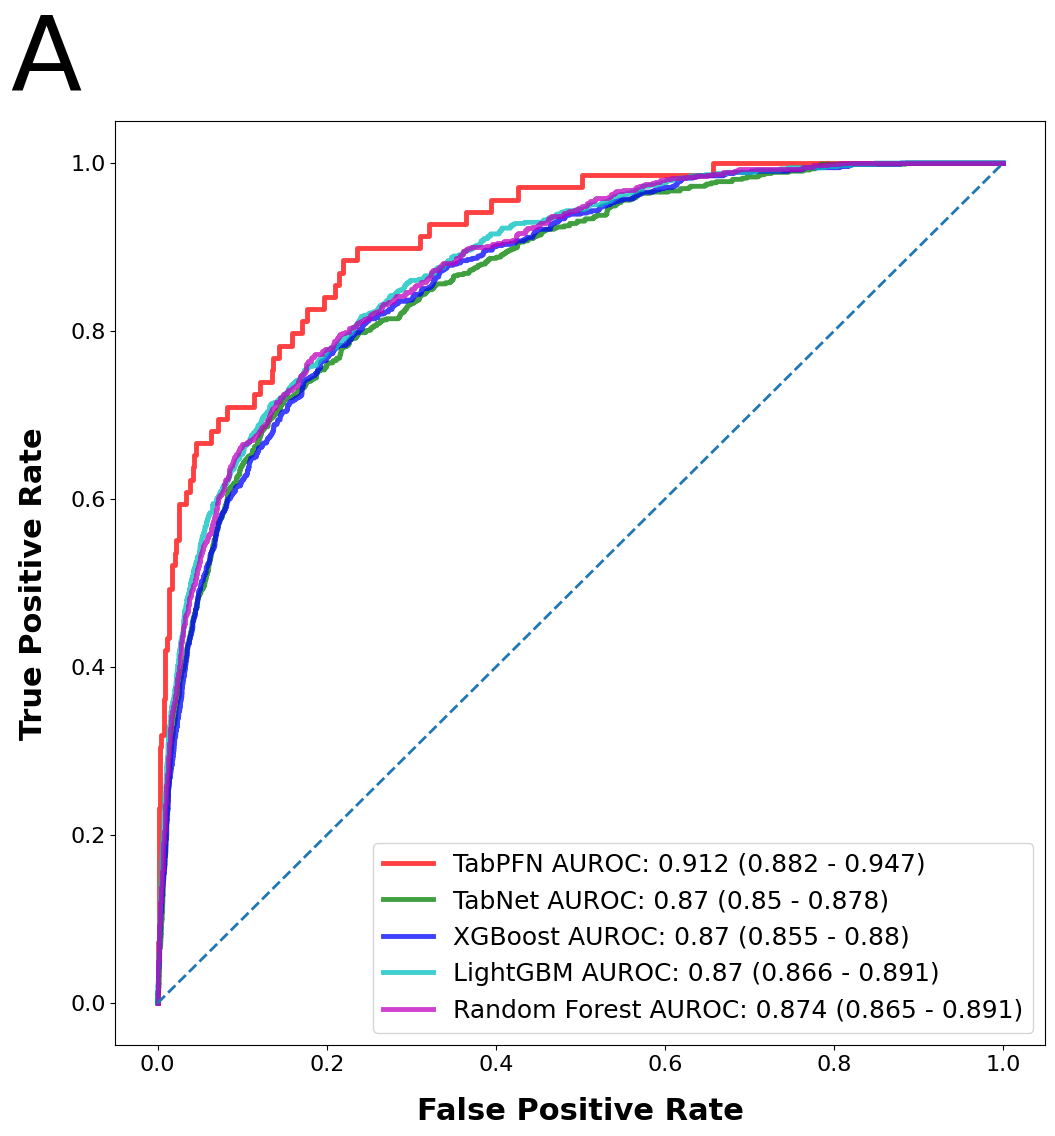

In [50]:
#Plot ROC curve.

f = pyplot.figure()
f.set_figwidth(12)
f.set_figheight(12)

tabpfn_fpr, tabpfn_tpr, _ = roc_curve(tabpfn_y_test, probs_tabpfn)
tabpfn_label = 'TabPFN AUROC: ' + tabpfn_auroc_str
pyplot.plot(tabpfn_fpr, tabpfn_tpr, label = tabpfn_label, color = 'r', linewidth = 3.5, alpha = 0.75)

tabnet_fpr, tabnet_tpr, _ = roc_curve(y_test, probs_tabnet)
tabnet_label = 'TabNet AUROC: ' + tabnet_auroc_str
pyplot.plot(tabnet_fpr, tabnet_tpr, label = tabnet_label, color = 'g', linewidth = 3.5, alpha = 0.75)

xgb_fpr, xgb_tpr, _ = roc_curve(y_test, probs_xgb)
xgb_label = 'XGBoost AUROC: ' + xgb_auroc_str
pyplot.plot(xgb_fpr, xgb_tpr, label = xgb_label, color = 'b', linewidth = 3.5, alpha = 0.75)

lgb_fpr, lgb_tpr, _ = roc_curve(y_test, probs_lgb)
lgb_label = 'LightGBM AUROC: ' + lgb_auroc_str
pyplot.plot(lgb_fpr, lgb_tpr, label = lgb_label, color='c', linewidth = 3.5, alpha = 0.75)

rf_fpr, rf_tpr, _ = roc_curve(y_test, probs_rf)
rf_label = 'Random Forest AUROC: ' + rf_auroc_str
pyplot.plot(rf_fpr, rf_tpr, label = rf_label, color = 'm', linewidth = 3.5, alpha = 0.75)

pyplot.plot([0, 1], [0, 1], linestyle = '--', linewidth=2)

pyplot.title('A', x = -0.075, y = 1.005, fontsize = 75, pad = 20)
pyplot.xlabel('False Positive Rate', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.ylabel('True Positive Rate', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.tick_params(axis="y",direction="out", labelsize = 16)
pyplot.tick_params(axis="x",direction="out", labelsize = 16)

leg = pyplot.legend(loc = 'lower right', fontsize = 18)

#pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/mortality_roc.png', dpi=300)
pyplot.show()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


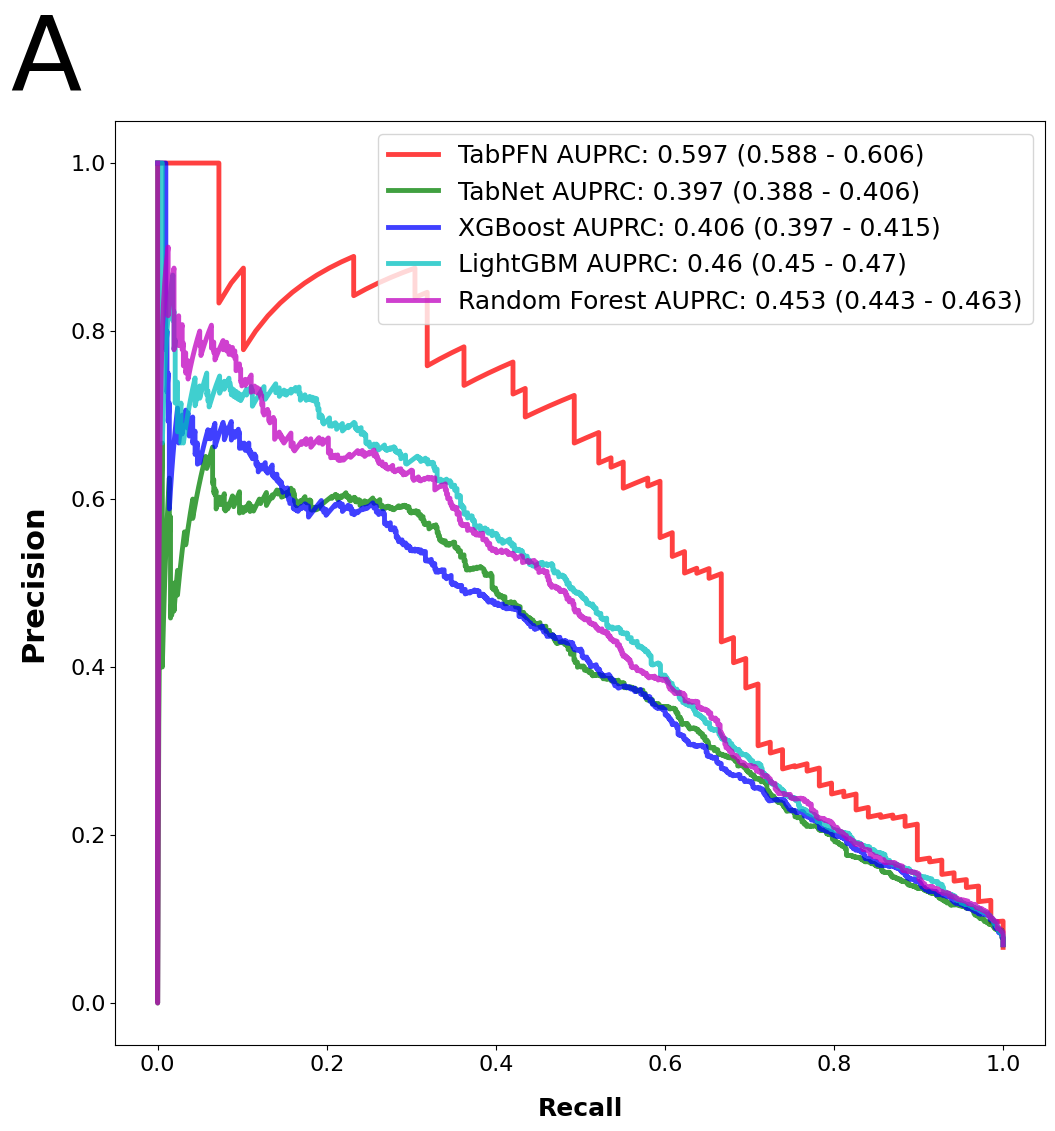

In [51]:
#Plot PR curve.

f = pyplot.figure()
f.set_figwidth(12)
f.set_figheight(12)

tabpfn_label = 'TabPFN AUPRC: ' + tabpfn_auprc_str
tabnet_label = 'TabNet AUPRC: ' + tabnet_auprc_str
xgb_label = 'XGBoost AUPRC: ' + xgb_auprc_str
lgb_label = 'LightGBM AUPRC: ' + lgb_auprc_str
rf_label = 'Random Forest AUPRC: ' + rf_auprc_str

pyplot.plot(tabpfn_recall_curve, tabpfn_precision_curve, label = tabpfn_label, color = 'r', linewidth = 3.5, alpha = 0.75)
pyplot.plot(tabnet_recall_curve, tabnet_precision_curve, label = tabnet_label, color = 'g', linewidth = 3.5, alpha = 0.75)
pyplot.plot(xgb_recall_curve, xgb_precision_curve, label = xgb_label, color = 'b', linewidth = 3.5, alpha = 0.75)
pyplot.plot(lgb_recall_curve, lgb_precision_curve, label = lgb_label, color = 'c', linewidth = 3.5, alpha = 0.75)
pyplot.plot(rf_recall_curve, rf_precision_curve, label = rf_label, color = 'm', linewidth = 3.5, alpha = 0.75)

pyplot.title('A', x = -0.075, y = 1.005, fontsize = 75, pad = 20)
pyplot.xlabel('Recall', fontsize = 18, fontweight = 'heavy', labelpad = 16)
pyplot.ylabel('Precision', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.tick_params(axis="y",direction="out", labelsize = 16)
pyplot.tick_params(axis="x",direction="out", labelsize = 16)

leg = pyplot.legend(loc = 'upper right', fontsize = 18)

#pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/mortality_prc.png', dpi=300)
pyplot.show()

# Results Summary

In [52]:
#Calculate means.

mean_precision = round((sum(list([tabpfn_precision, tabnet_precision, xgb_precision, lgb_precision, rf_precision]))/5), 3)
mean_precision_ci_lower = round((sum(list([tabpfn_precision_ci_lower, tabnet_precision_ci_lower, xgb_precision_ci_lower, lgb_precision_ci_lower, rf_precision_ci_lower]))/5), 3)
mean_precision_ci_upper = round((sum(list([tabpfn_precision_ci_upper, tabnet_precision_ci_upper, xgb_precision_ci_upper, lgb_precision_ci_upper, rf_precision_ci_upper]))/5), 3)
mean_precision_str = str(mean_precision) + ' (' + str(mean_precision_ci_lower) + ' - ' + str(mean_precision_ci_upper) + ')'

mean_recall = round((sum(list([tabpfn_recall, tabnet_recall, xgb_recall, lgb_recall, rf_recall]))/5), 3)
mean_recall_ci_lower = round((sum(list([tabpfn_recall_ci_lower, tabnet_recall_ci_lower, xgb_recall_ci_lower, lgb_recall_ci_lower, rf_recall_ci_lower]))/5), 3)
mean_recall_ci_upper = round((sum(list([tabpfn_recall_ci_upper, tabnet_recall_ci_upper, xgb_recall_ci_upper, lgb_recall_ci_upper, rf_recall_ci_upper]))/5), 3)
mean_recall_str = str(mean_recall) + ' (' + str(mean_recall_ci_lower) + ' - ' + str(mean_recall_ci_upper) + ')'

mean_auprc = round((sum(list([tabpfn_auprc, tabnet_auprc, xgb_auprc, lgb_auprc, rf_auprc]))/5), 3)
mean_auprc_ci_lower = round((sum(list([tabpfn_auprc_ci_lower, tabnet_auprc_ci_lower, xgb_auprc_ci_lower, lgb_auprc_ci_lower, rf_auprc_ci_lower]))/5), 3)
mean_auprc_ci_upper = round((sum(list([tabpfn_auprc_ci_upper, tabnet_auprc_ci_upper, xgb_auprc_ci_upper, lgb_auprc_ci_upper, rf_auprc_ci_upper]))/5), 3)
mean_auprc_str = str(mean_auprc) + ' (' + str(mean_auprc_ci_lower) + ' - ' + str(mean_auprc_ci_upper) + ')'

mean_accuracy = round((sum(list([tabpfn_accuracy, tabnet_accuracy, xgb_accuracy, lgb_accuracy, rf_accuracy]))/5), 3)
mean_accuracy_ci_lower = round((sum(list([tabpfn_accuracy_ci_lower, tabnet_accuracy_ci_lower, xgb_accuracy_ci_lower, lgb_accuracy_ci_lower, rf_accuracy_ci_lower]))/5), 3)
mean_accuracy_ci_upper = round((sum(list([tabpfn_accuracy_ci_upper, tabnet_accuracy_ci_upper, xgb_accuracy_ci_upper, lgb_accuracy_ci_upper, rf_accuracy_ci_upper]))/5), 3)
mean_accuracy_str = str(mean_accuracy) + ' (' + str(mean_accuracy_ci_lower) + ' - ' + str(mean_accuracy_ci_upper) + ')'

mean_auroc = round((sum(list([tabpfn_auroc, tabnet_auroc, xgb_auroc, lgb_auroc, rf_auroc]))/5), 3)
mean_auroc_ci_lower = round((sum(list([tabpfn_auroc_ci_lower, tabnet_auroc_ci_lower, xgb_auroc_ci_lower, lgb_auroc_ci_lower, rf_auroc_ci_lower]))/5), 3)
mean_auroc_ci_upper = round((sum(list([tabpfn_auroc_ci_upper, tabnet_auroc_ci_upper, xgb_auroc_ci_upper, lgb_auroc_ci_upper, rf_auroc_ci_upper]))/5), 3)
mean_auroc_str = str(mean_auroc) + ' (' + str(mean_auroc_ci_lower) + ' - ' + str(mean_auroc_ci_upper) + ')'

mean_brier = round((sum(list([tabpfn_brier, tabnet_brier, xgb_brier, lgb_brier, rf_brier]))/5), 3)
mean_brier_ci_lower = round((sum(list([tabpfn_brier_ci_lower, tabnet_brier_ci_lower, xgb_brier_ci_lower, lgb_brier_ci_lower, rf_brier_ci_lower]))/5), 3)
mean_brier_ci_upper = round((sum(list([tabpfn_brier_ci_upper, tabnet_brier_ci_upper, xgb_brier_ci_upper, lgb_brier_ci_upper, rf_brier_ci_upper]))/5), 3)
mean_brier_str = str(mean_brier) + ' (' + str(mean_brier_ci_lower) + ' - ' + str(mean_brier_ci_upper) + ')'

mean_results = [mean_precision_str, mean_recall_str, mean_auprc_str, mean_accuracy_str, mean_auroc_str, mean_brier_str]

In [53]:
results = {'TabPFN':tabpfn_results, 'TabNet':tabnet_results, 'XGBoost':xgb_results, 'LightGBM':lgb_results, 'Random Forest':rf_results, 'Mean':mean_results}

results = pd.DataFrame(results, columns = ['TabPFN', 'TabNet', 'XGBoost', 'LightGBM', 'Random Forest', 'Mean'])

results

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
_PyDriveImportHook.find_spec() not found; falling back to find_module()
_OpenCVImportHook.find_spec() not found; falling back to find_module()
_BokehImportHook.find_spec() not found; falling back to find_module()
_AltairImportHook.find_spec() not found; falling back to find_module()
APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
_PyDriveImportHook.find_spec() not found; falling back to find_module()
_OpenCVImportHook.find_spec() not found; falling back to find_module()
_BokehImportHook.find_spec() not found; falling back to find_module()
_AltairImportHook.find_spec() not found; falling back to find_module()


TabPFN                 TabNet                XGBoost  \
0  0.934 (0.929 - 0.939)    0.925 (0.92 - 0.93)  0.926 (0.921 - 0.931)   
1   0.827 (0.82 - 0.834)   0.788 (0.78 - 0.796)  0.793 (0.785 - 0.801)   
2  0.597 (0.588 - 0.606)  0.397 (0.388 - 0.406)  0.406 (0.397 - 0.415)   
3   0.813 (0.806 - 0.82)  0.777 (0.769 - 0.785)  0.784 (0.776 - 0.792)   
4  0.912 (0.882 - 0.947)    0.87 (0.85 - 0.878)    0.87 (0.855 - 0.88)   
5  0.043 (0.039 - 0.047)  0.051 (0.047 - 0.055)  0.052 (0.048 - 0.056)   

                LightGBM          Random Forest                   Mean  
0  0.927 (0.922 - 0.932)  0.928 (0.923 - 0.933)  0.928 (0.923 - 0.933)  
1   0.812 (0.804 - 0.82)  0.803 (0.795 - 0.811)  0.805 (0.797 - 0.812)  
2     0.46 (0.45 - 0.47)  0.453 (0.443 - 0.463)  0.463 (0.453 - 0.472)  
3  0.787 (0.779 - 0.795)  0.791 (0.783 - 0.799)   0.79 (0.783 - 0.798)  
4   0.87 (0.866 - 0.891)  0.874 (0.865 - 0.891)  0.879 (0.864 - 0.897)  
5   0.05 (0.046 - 0.054)  0.049 (0.045 - 0.053)  0.049 (0.045 - 0.053)

In [54]:
results = pd.DataFrame({'TabPFN':tabpfn_results, 'TabNet':tabnet_results, 'XGBoost':xgb_results, 'LightGBM':lgb_results, 'Random Forest':rf_results, 'Mean':mean_results})

results = results.T

results.columns = ['Weighted Precision (95% CI)', 'Weighted Recall (95% CI)',  'Weighted AUPRC (95% CI)', 'Balanced Accuracy (95% CI)', 'AUROC (95% CI)', 'Brier Score']

#results.to_csv('/content/drive/MyDrive/TQP-atSDH/mortality_results.csv')

results

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Weighted Precision (95% CI) Weighted Recall (95% CI)  \
TabPFN              0.934 (0.929 - 0.939)     0.827 (0.82 - 0.834)   
TabNet                0.925 (0.92 - 0.93)     0.788 (0.78 - 0.796)   
XGBoost             0.926 (0.921 - 0.931)    0.793 (0.785 - 0.801)   
LightGBM            0.927 (0.922 - 0.932)     0.812 (0.804 - 0.82)   
Random Forest       0.928 (0.923 - 0.933)    0.803 (0.795 - 0.811)   
Mean                0.928 (0.923 - 0.933)    0.805 (0.797 - 0.812)   

              Weighted AUPRC (95% CI) Balanced Accuracy (95% CI)  \
TabPFN          0.597 (0.588 - 0.606)       0.813 (0.806 - 0.82)   
TabNet          0.397 (0.388 - 0.406)      0.777 (0.769 - 0.785)   
XGBoost         0.406 (0.397 - 0.415)      0.784 (0.776 - 0.792)   
LightGBM           0.46 (0.45 - 0.47)      0.787 (0.779 - 0.795)   
Random Forest   0.453 (0.443 - 0.463)      0.791 (0.783 - 0.799)   
Mean            0.463 (0.453 - 0.472)       0.79 (0.783 - 0.798)   

                      AUROC (95% CI)            Brier Score  
TabPFN         0.912 (0.882 - 0.947)  0.043 (0.039 - 0.047)  
TabNet           0.87 (0.85 - 0.878)  0.051 (0.047 - 0.055)  
XGBoost          0.87 (0.855 - 0.88)  0.052 (0.048 - 0.056)  
LightGBM        0.87 (0.866 - 0.891)   0.05 (0.046 - 0.054)  
Random Forest  0.874 (0.865 - 0.891)  0.049 (0.045 - 0.053)  
Mean           0.879 (0.864 - 0.897)  0.049 (0.045 - 0.053)

# SHAP Plots

In [55]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width, 
                                    break_long_words=break_long_words))
    ax.set_yticklabels(labels, rotation=0)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [56]:
x_test = x_test[x_test['Age'] > 18]
x_test = x_test[x_test['Age'] < 90]

x_test = x_test[x_test['Weight'] > 30]
x_test = x_test[x_test['Weight'] < 250]

x_test = x_test[x_test['Height'] > 100]
x_test = x_test[x_test['Height'] < 220]

x_test = x_test[x_test['Systolic Blood Pressure'] > 50]
x_test = x_test[x_test['Systolic Blood Pressure'] < 250]

x_test = x_test[x_test['Pulse Rate'] > 20]
x_test = x_test[x_test['Pulse Rate'] < 220]

x_test = x_test[x_test['Pulse Oximetry'] > 70]
x_test = x_test[x_test['Pulse Oximetry'] < 100]

x_test = x_test[x_test['Respiratory Rate'] > 4]
x_test = x_test[x_test['Respiratory Rate'] < 50]

In [57]:
x_test_sample = x_test.sample(frac=0.05, random_state=42)
tabpfn_x_test_sample = tabpfn_x_test.sample(frac=0.05, random_state=42)
tabnet_x_test_sample = x_test.sample(frac=0.05, random_state = 31)

feature_names = x_test_sample.columns

In [58]:
#Calculate SHAP values for TabPFN.

tabpfn_explainer = shap.Explainer(tabpfn.predict, tabpfn_x_test_sample)
tabpfn_shap_values = tabpfn_explainer(tabpfn_x_test_sample)

Streaming output truncated to the last 5000 lines.
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify a

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


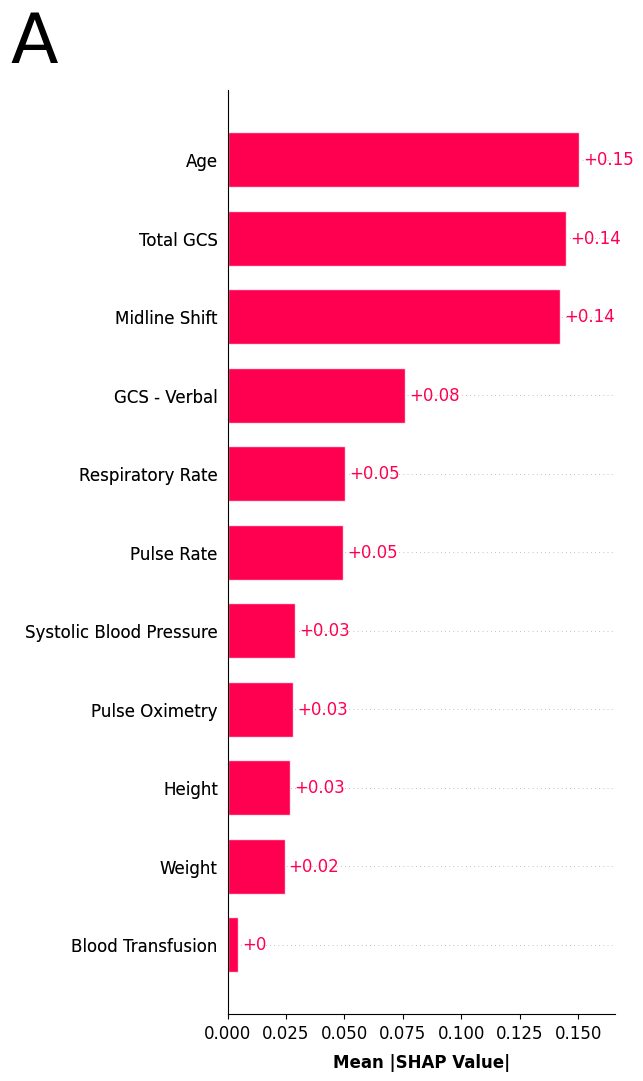

In [59]:
#Plot SHAP bar plot for TabPFN.

shap.plots.bar(tabpfn_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('A', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/mortality_shap_tabpfn.png', dpi=300, bbox_inches='tight')

In [60]:
#Calculate SHAP values for TabNet.

tabnet_explainer = shap.Explainer(tabnet.predict, x_test_sample.values, feature_names=feature_names)
tabnet_shap_values = tabnet_explainer(x_test_sample.values)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check th

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


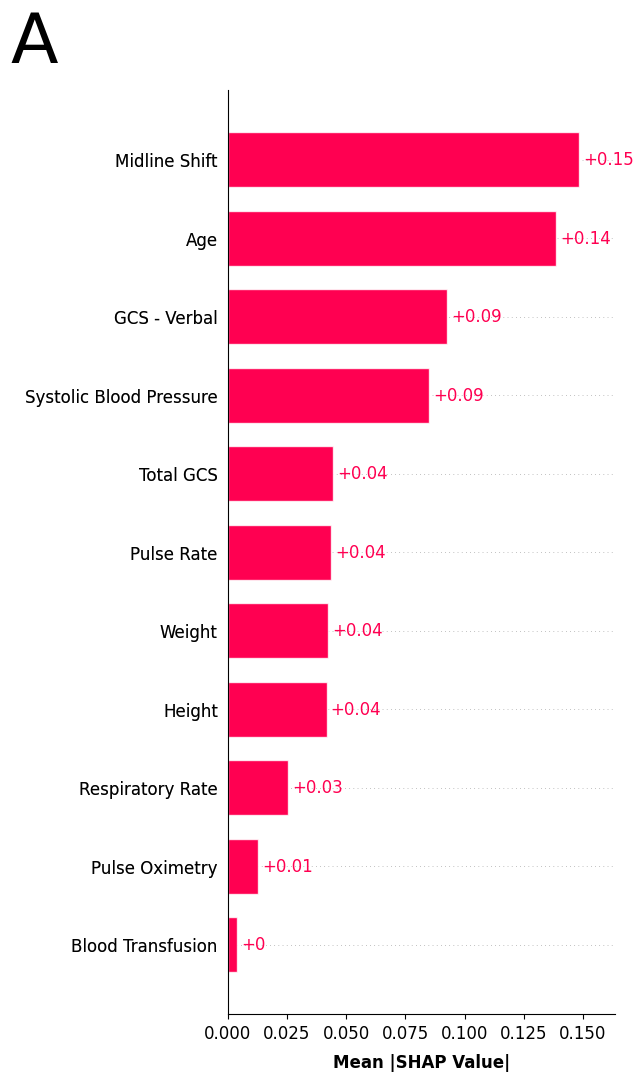

In [61]:
#Plot SHAP bar plot for TabNet.

shap.plots.bar(tabnet_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('A', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/mortality_shap_tabnet.png', dpi=300, bbox_inches='tight')

In [62]:
#Calculate SHAP values for XGBoost.

xgb_explainer = shap.Explainer(xgb.predict, x_test_sample)
xgb_shap_values = xgb_explainer(x_test_sample)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


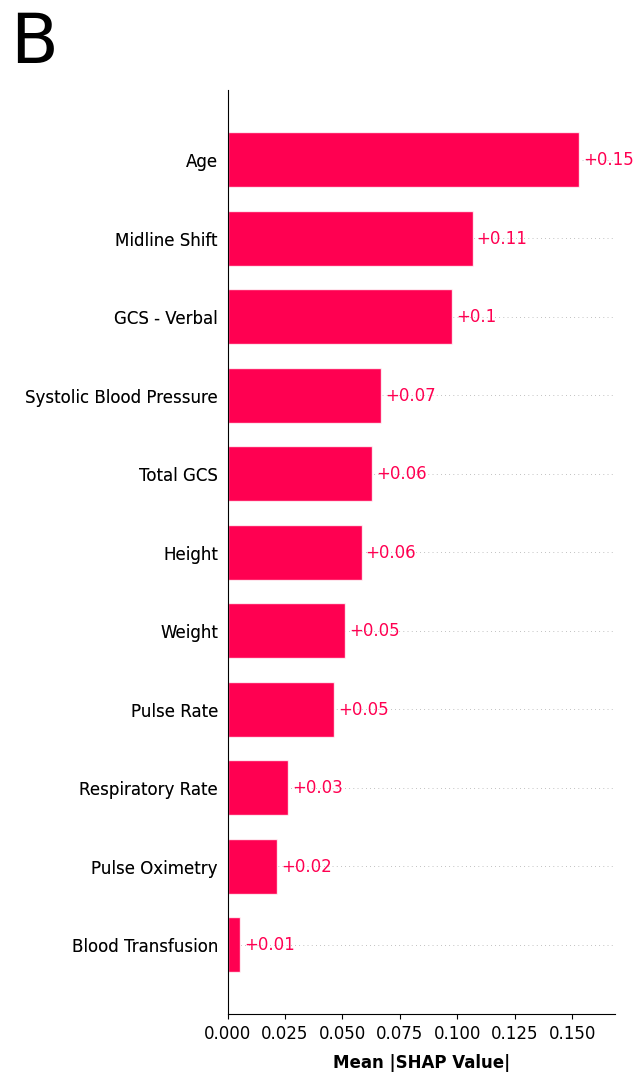

In [63]:
#Plot SHAP bar plot for XGBoost.

shap.plots.bar(xgb_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('B', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/mortality_shap_xgb.png', dpi=300, bbox_inches='tight')

In [64]:
#Calculate SHAP values for LightGBM.

lgb_explainer = shap.Explainer(lgb.predict, x_test_sample)
lgb_shap_values = lgb_explainer(x_test_sample)

Streaming output truncated to the last 5000 lines.
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify a

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


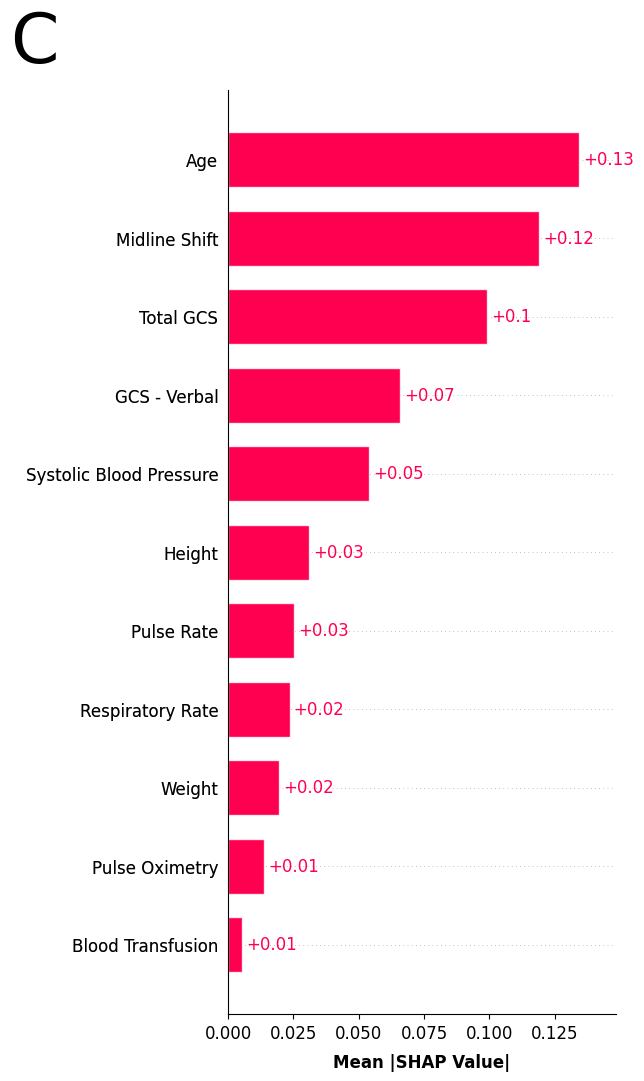

In [65]:
#Plot SHAP bar plot for LightGBM.

shap.plots.bar(lgb_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('C', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/mortality_shap_lgb.png', dpi=300, bbox_inches='tight')

In [66]:
#Calculate SHAP values for Random Forest.

rf_explainer = shap.Explainer(rf.predict, x_test_sample)
rf_shap_values = rf_explainer(x_test_sample)

Streaming output truncated to the last 5000 lines.
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify a

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


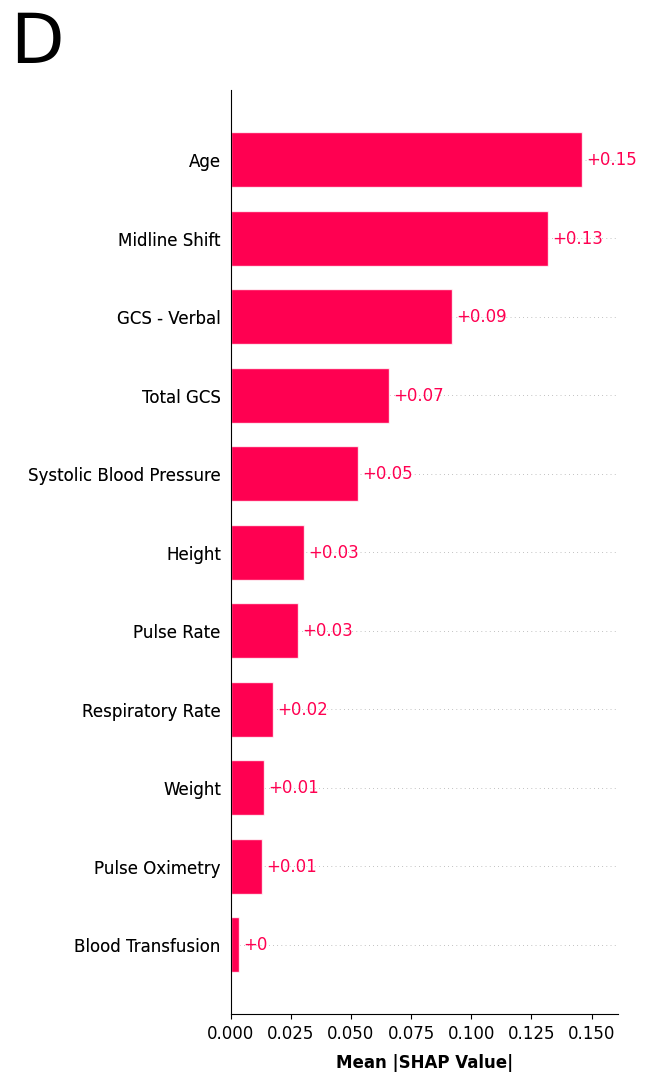

In [67]:
#Plot SHAP bar plot for Random Forest.

shap.plots.bar(rf_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('D', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/mortality_shap_rf.png', dpi=300, bbox_inches='tight')

#Partial Dependency Plots

In [68]:
pyplot.rcParams["figure.figsize"] = (15, 20)
pyplot.rcParams["figure.dpi"] = 300
pyplot.rcParams['axes.labelweight'] = 'bold'
pyplot.rcParams['axes.labelsize'] = 12
pyplot.rcParams['axes.labelpad'] = 6
pyplot.rcParams['font.weight'] = 'normal'
pyplot.rcParams['lines.linewidth'] = 2.5
pyplot.rcParams['xtick.labelsize'] = 8
pyplot.rcParams['ytick.labelsize'] = 8

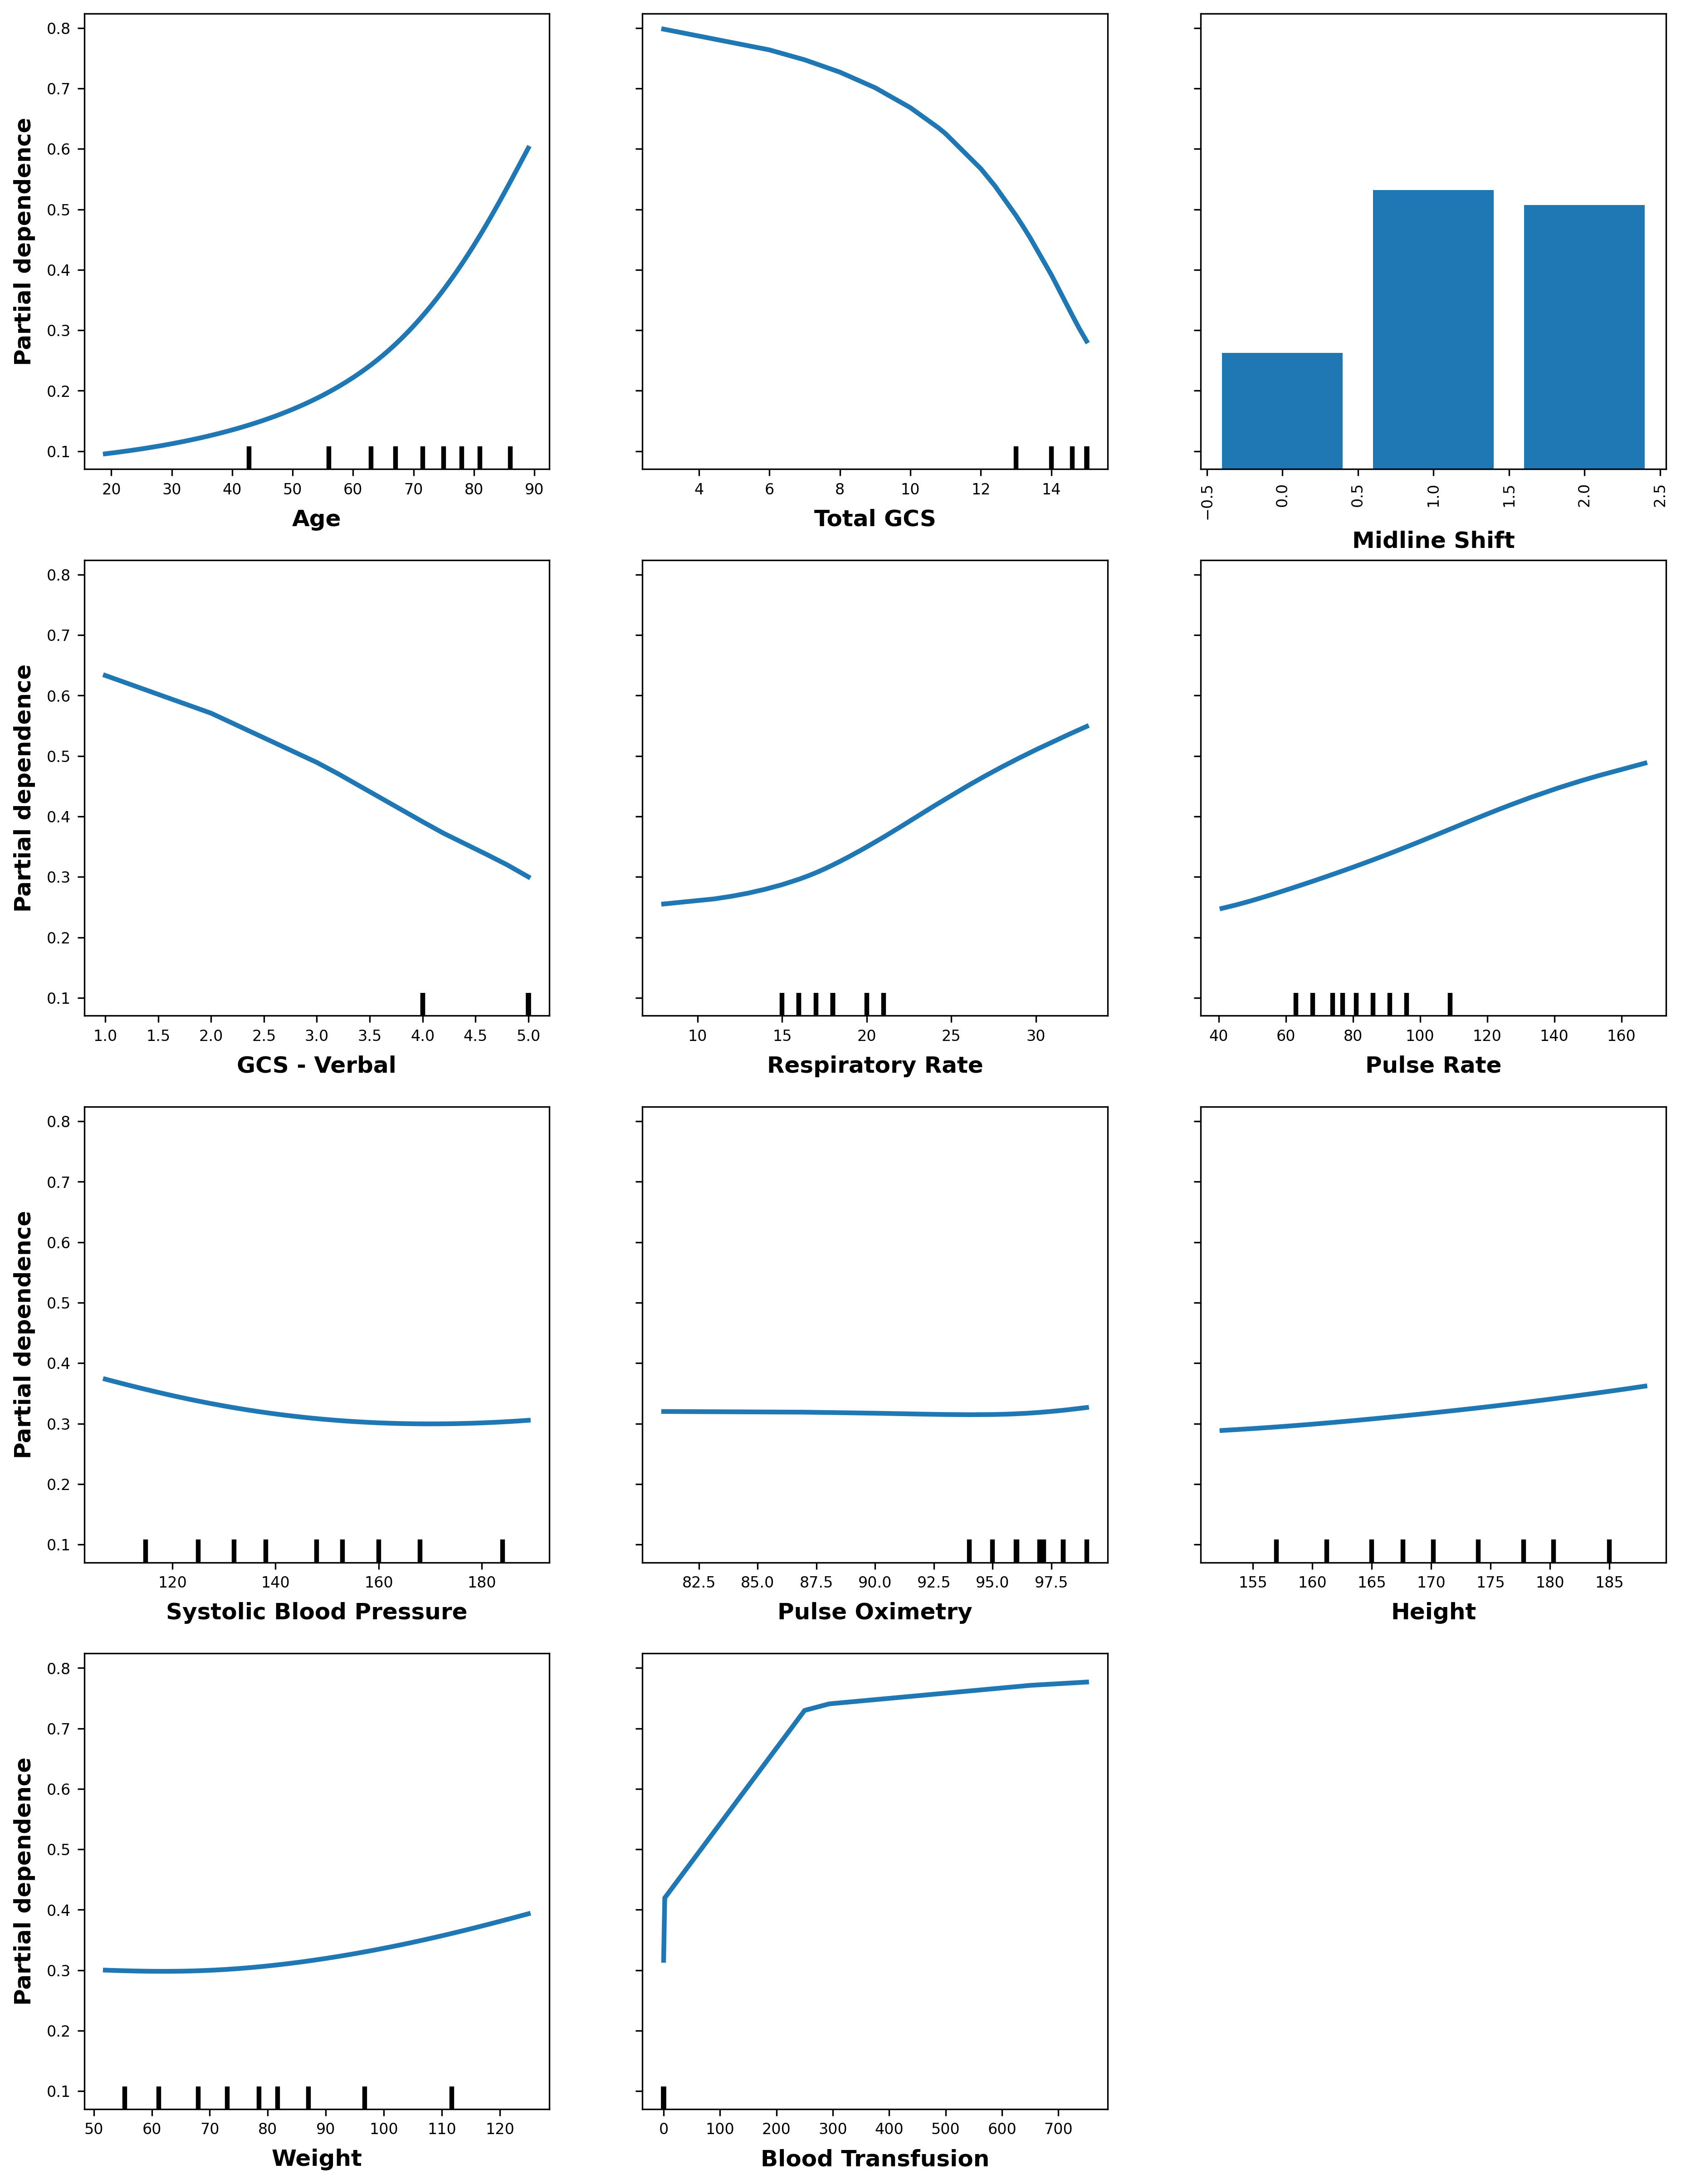

In [69]:
#Calculate the mean absolute SHAP values for each feature.
tabpfn_mean_abs_shap_values = np.mean(np.abs(tabpfn_shap_values.values), axis=0)

#Create a DataFrame to map feature names to their mean absolute SHAP values.
tabpfn_shap_summary = pd.DataFrame(list(zip(feature_names, tabpfn_mean_abs_shap_values)), columns=['Feature', 'Mean SHAP'])

#Sort the DataFrame by 'Mean SHAP' in descending order.
tabpfn_shap_summary_sorted = tabpfn_shap_summary.sort_values('Mean SHAP', ascending=False)

#Get the names of the features.
tabpfn_features = tabpfn_shap_summary_sorted['Feature'].tolist()

PartialDependenceDisplay.from_estimator(tabpfn, x_test_sample, tabpfn_features, categorical_features = ['Midline Shift'])
pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/mortality_pdp_tabpfn.png', dpi=300, bbox_inches='tight')
pyplot.show()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


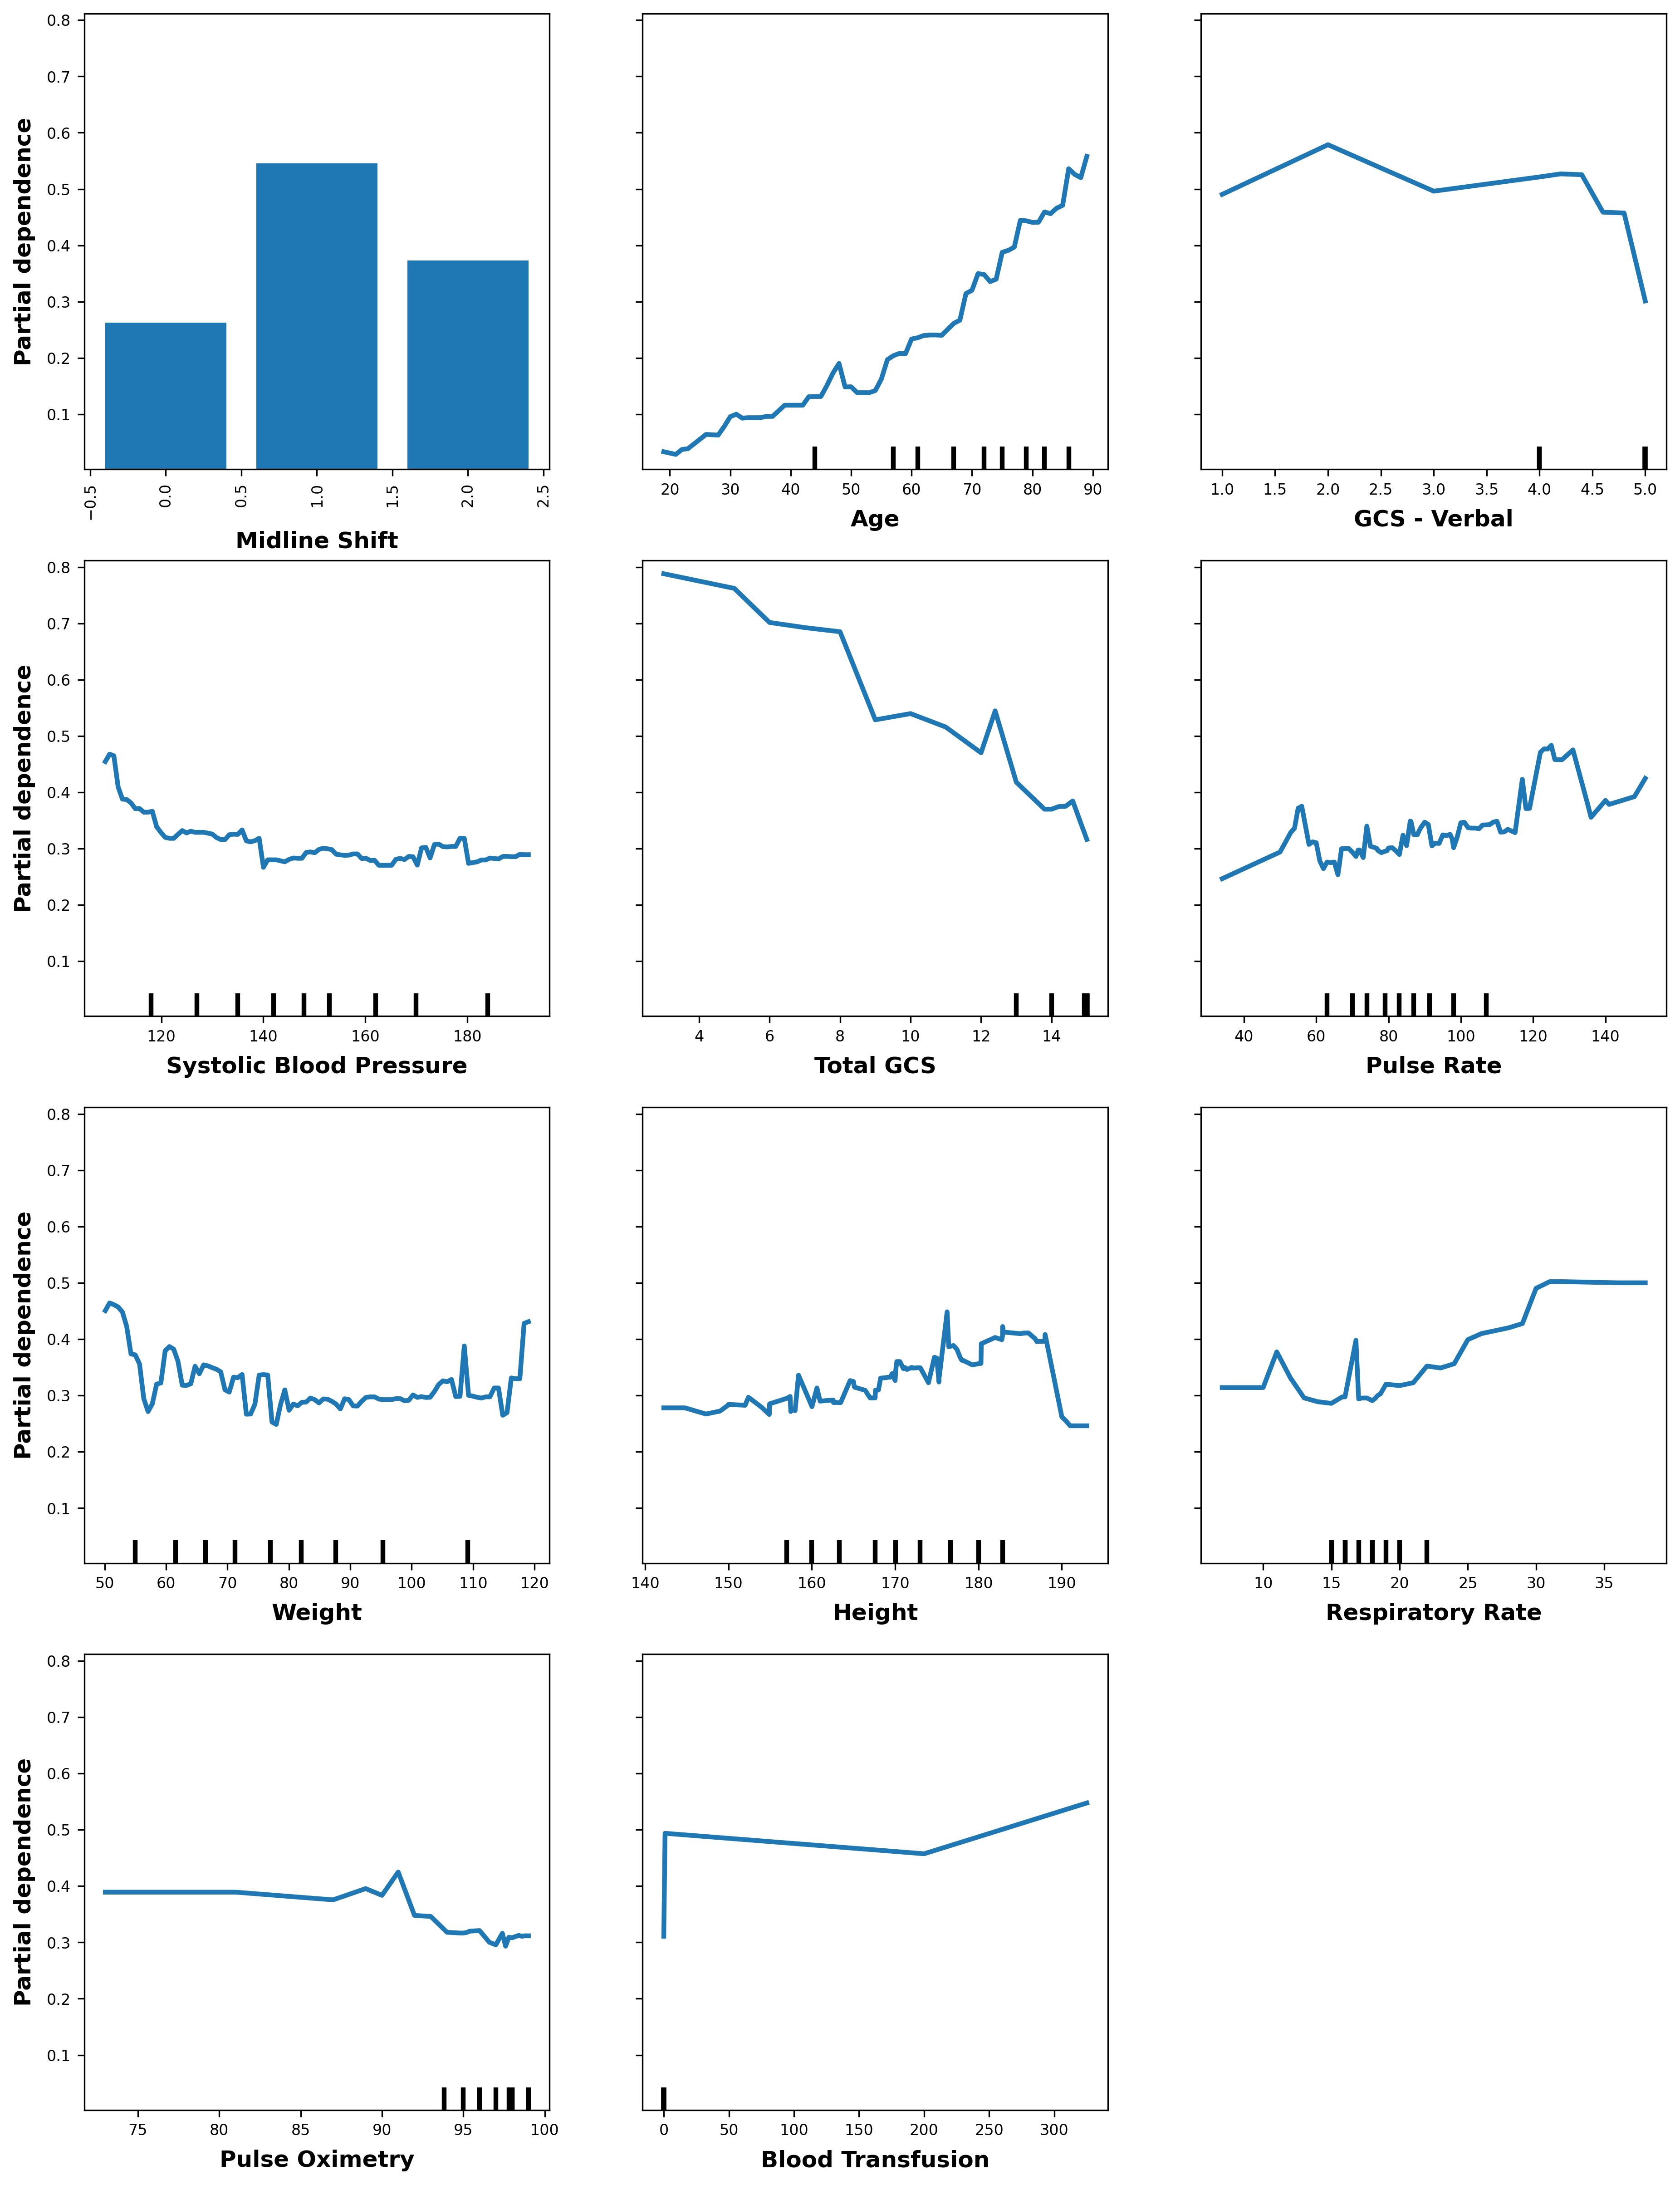

In [70]:
#Calculate the mean absolute SHAP values for each feature.
tabnet_mean_abs_shap_values = np.mean(np.abs(tabnet_shap_values.values), axis=0)

#Create a DataFrame to map feature names to their mean absolute SHAP values.
tabnet_shap_summary = pd.DataFrame(list(zip(feature_names, tabnet_mean_abs_shap_values)), columns=['Feature', 'Mean SHAP'])

#Sort the DataFrame by 'Mean SHAP' in descending order.
tabnet_shap_summary_sorted = tabnet_shap_summary.sort_values('Mean SHAP', ascending=False)

#Get the names of the features.
tabnet_features = tabnet_shap_summary_sorted['Feature'].tolist()

PartialDependenceDisplay.from_estimator(xgb, tabnet_x_test_sample, tabnet_features, categorical_features = ['Midline Shift'])

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/mortality_pdp_tabnet.png', dpi=300, bbox_inches='tight')
pyplot.show()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


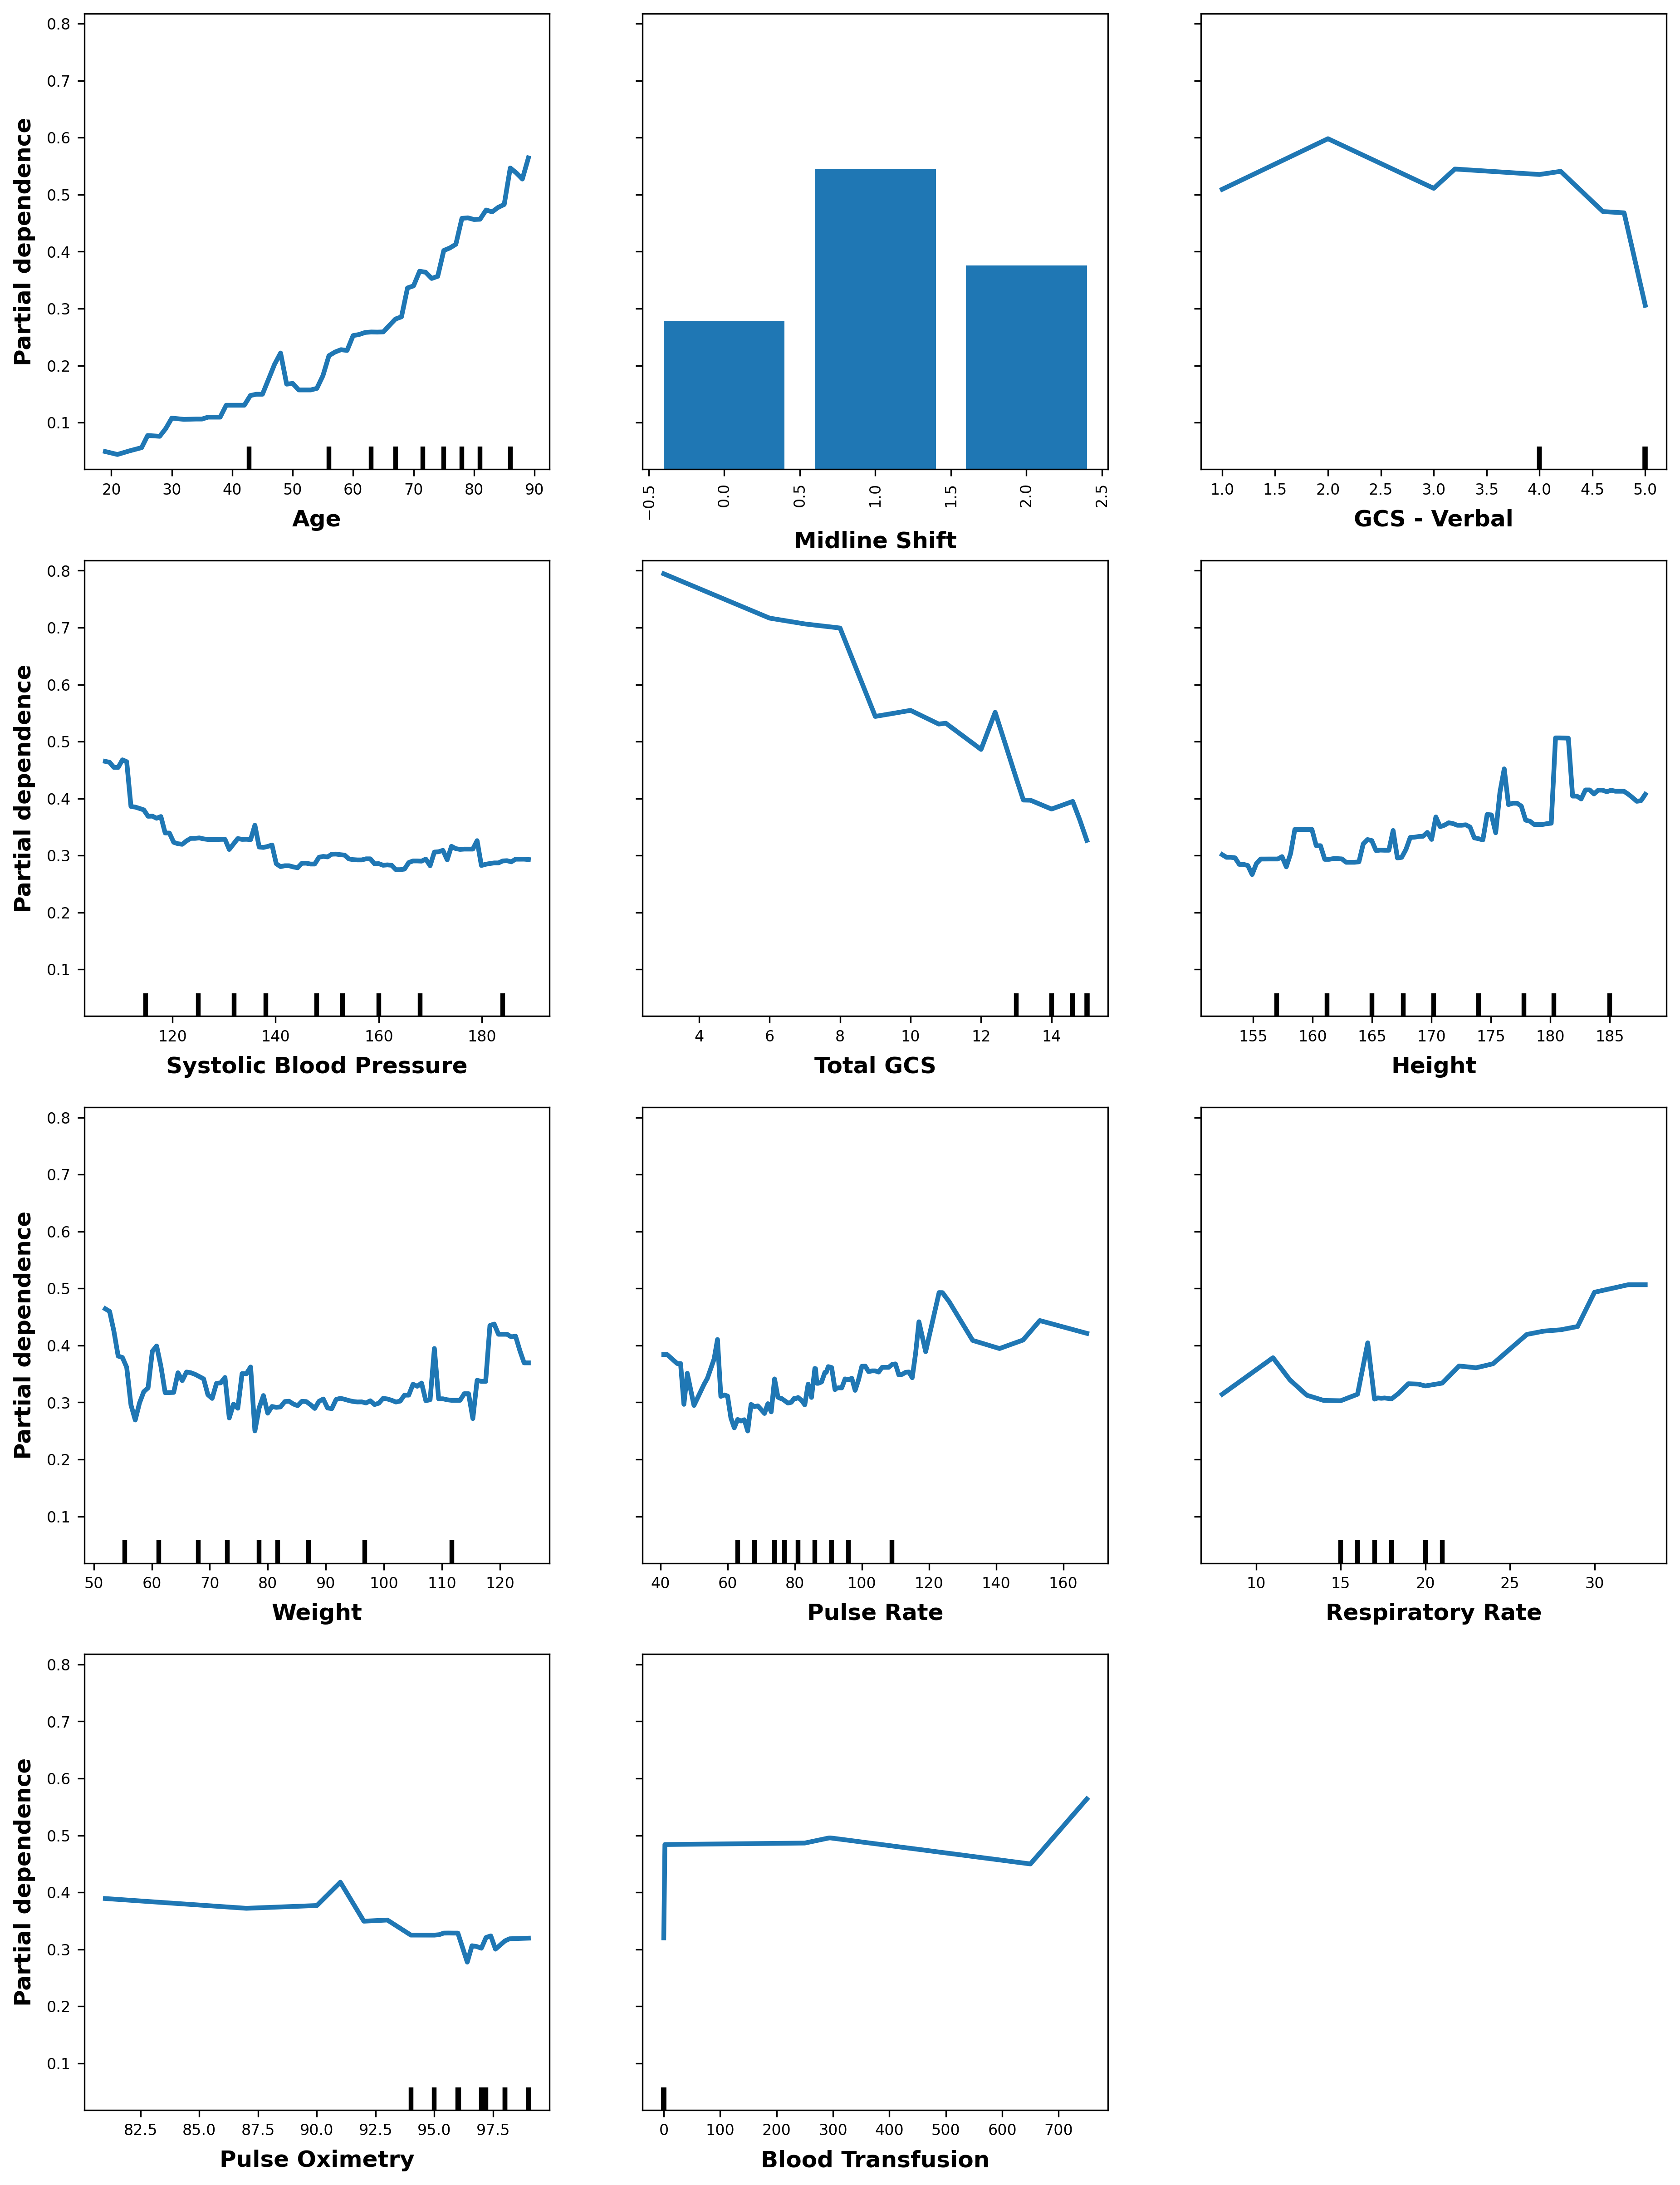

In [71]:
#Calculate the mean absolute SHAP values for each feature.
xgb_mean_abs_shap_values = np.mean(np.abs(xgb_shap_values.values), axis=0)

#Create a DataFrame to map feature names to their mean absolute SHAP values.
xgb_shap_summary = pd.DataFrame(list(zip(feature_names, xgb_mean_abs_shap_values)), columns=['Feature', 'Mean SHAP'])

#Sort the DataFrame by 'Mean SHAP' in descending order.
xgb_shap_summary_sorted = xgb_shap_summary.sort_values('Mean SHAP', ascending=False)

#Get the names of the features.
xgb_features = xgb_shap_summary_sorted['Feature'].tolist()

PartialDependenceDisplay.from_estimator(xgb, x_test_sample, xgb_features, categorical_features = ['Midline Shift'])
pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/mortality_pdp_xgb.png', dpi=300, bbox_inches='tight')
pyplot.show()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


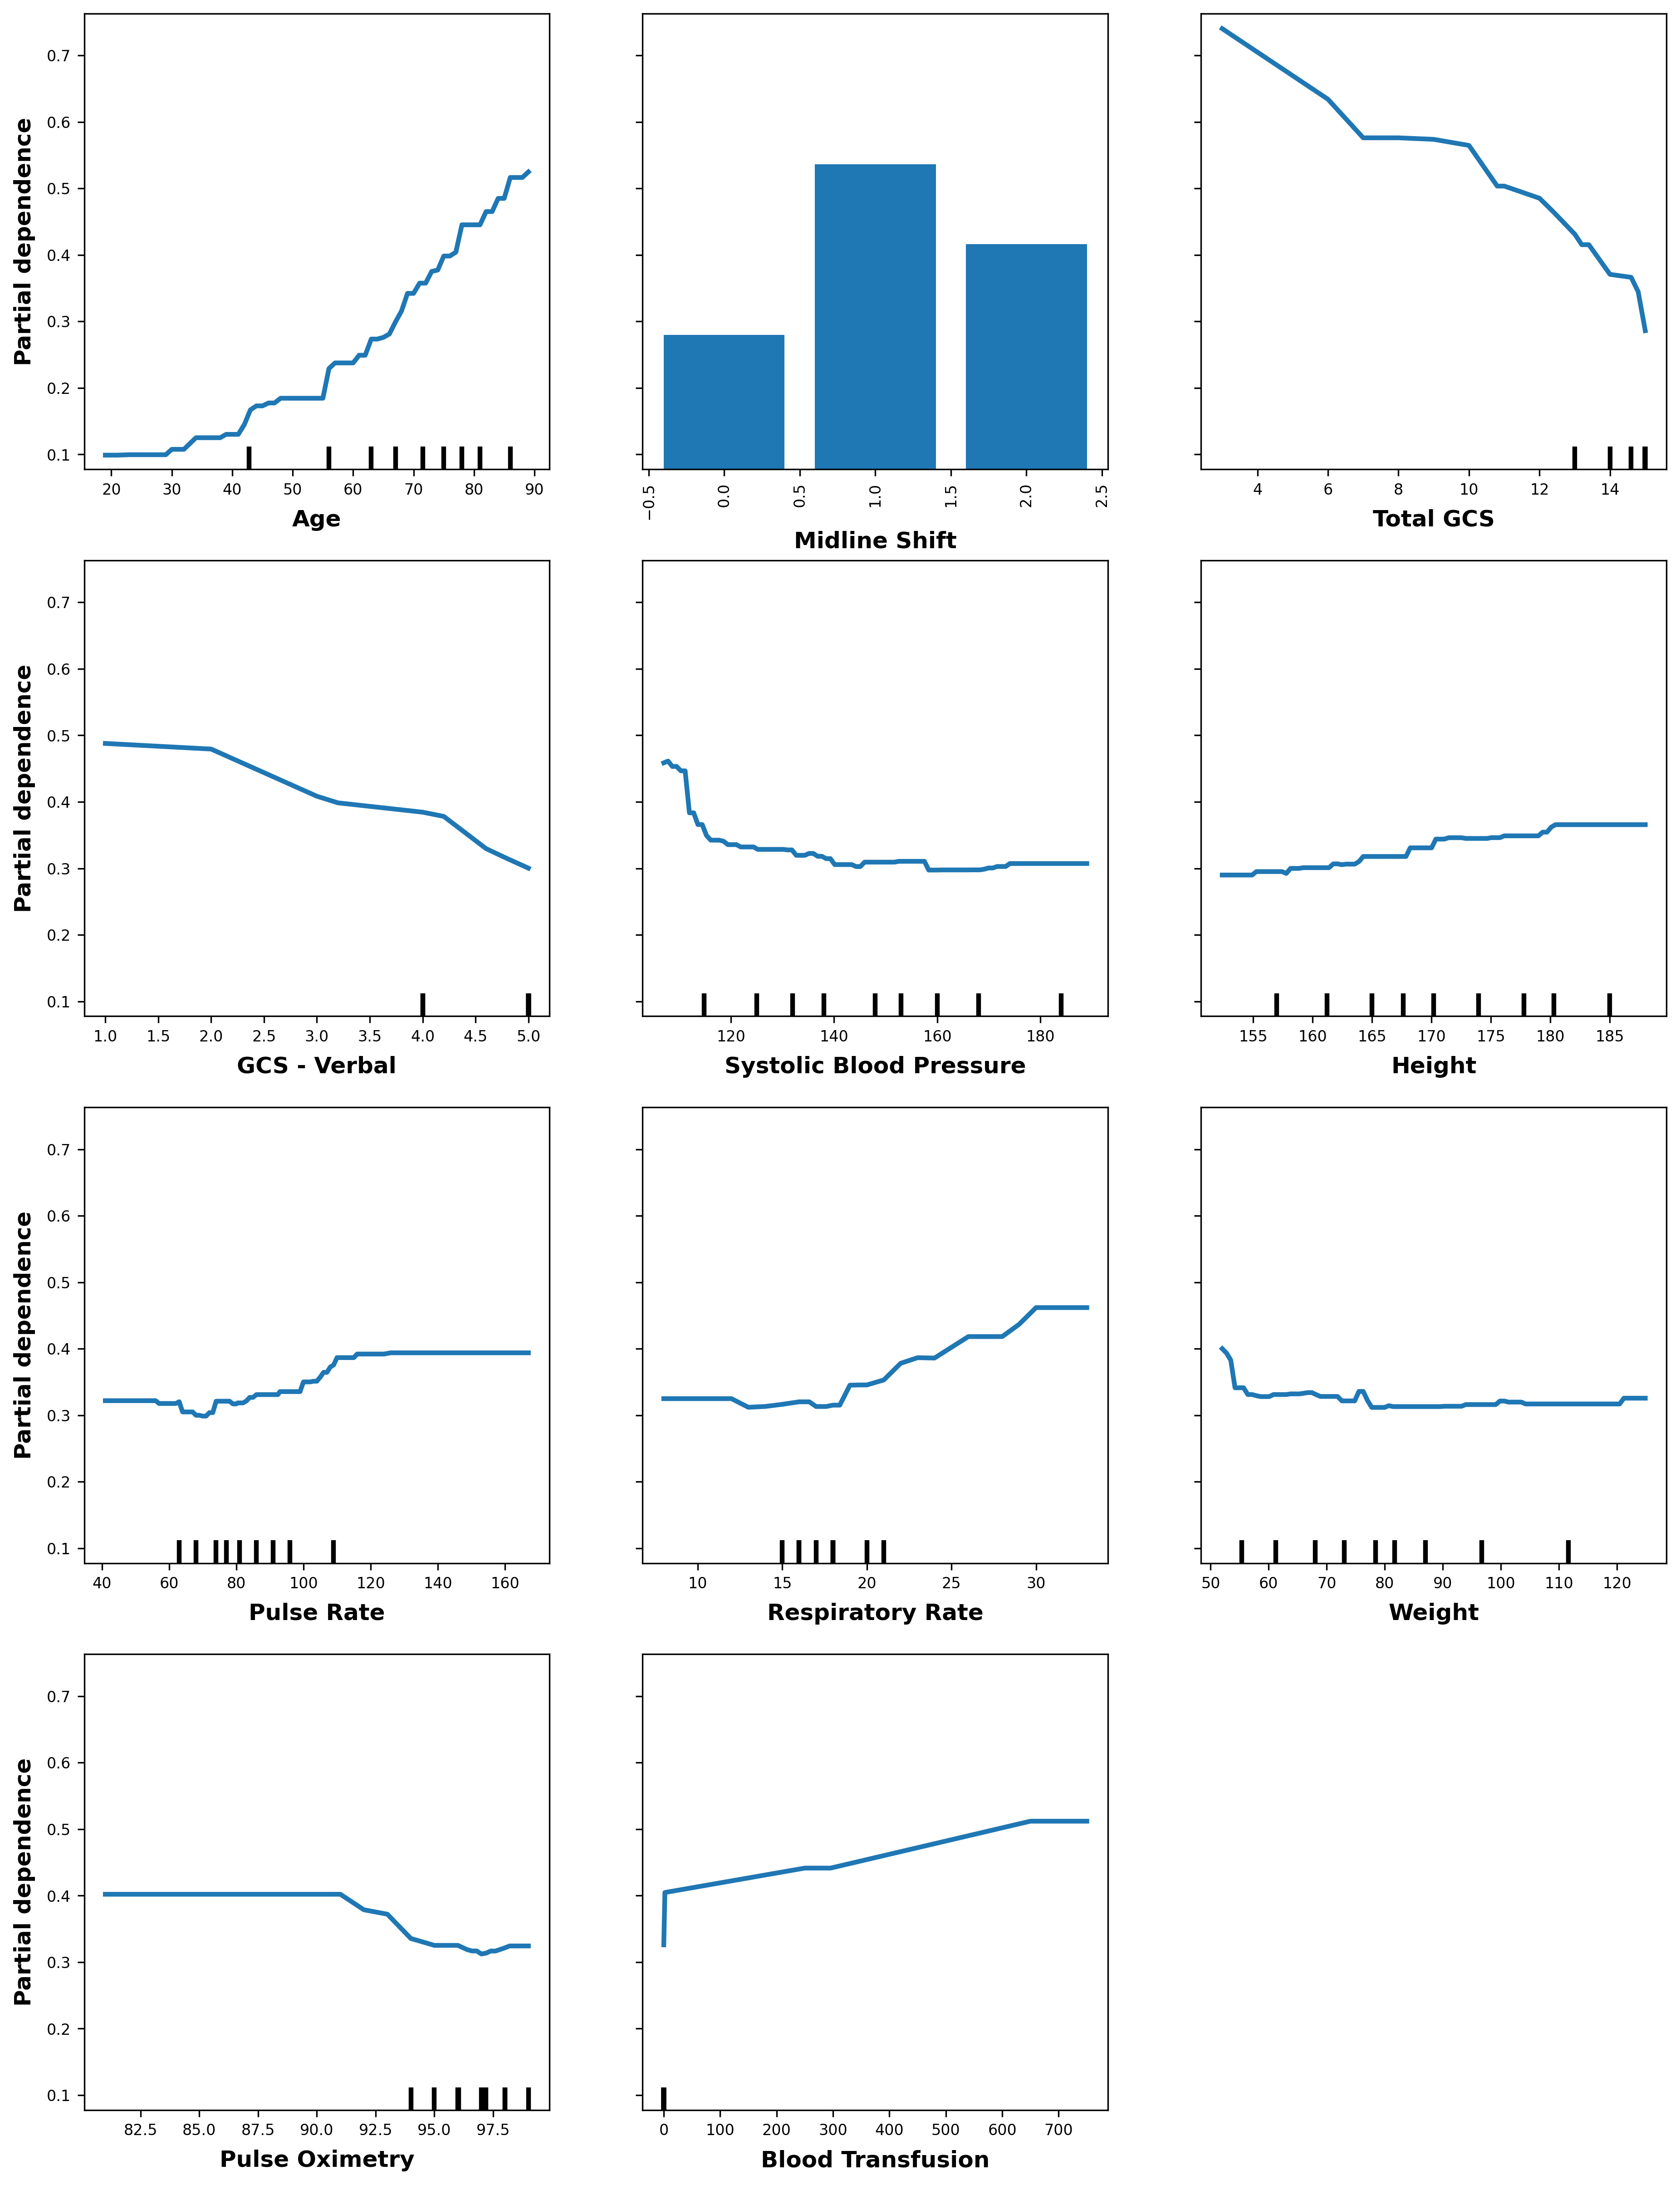

In [72]:
#Calculate the mean absolute SHAP values for each feature.
lgb_mean_abs_shap_values = np.mean(np.abs(lgb_shap_values.values), axis=0)

#Create a DataFrame to map feature names to their mean absolute SHAP values.
lgb_shap_summary = pd.DataFrame(list(zip(feature_names, lgb_mean_abs_shap_values)), columns=['Feature', 'Mean SHAP'])

#Sort the DataFrame by 'Mean SHAP' in descending order.
lgb_shap_summary_sorted = lgb_shap_summary.sort_values('Mean SHAP', ascending=False)

#Get the names of the features.
lgb_features = lgb_shap_summary_sorted['Feature'].tolist()

PartialDependenceDisplay.from_estimator(lgb, x_test_sample, lgb_features, categorical_features = ['Midline Shift'])
pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/mortality_pdp_lgb.png', dpi=300, bbox_inches='tight')
pyplot.show()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


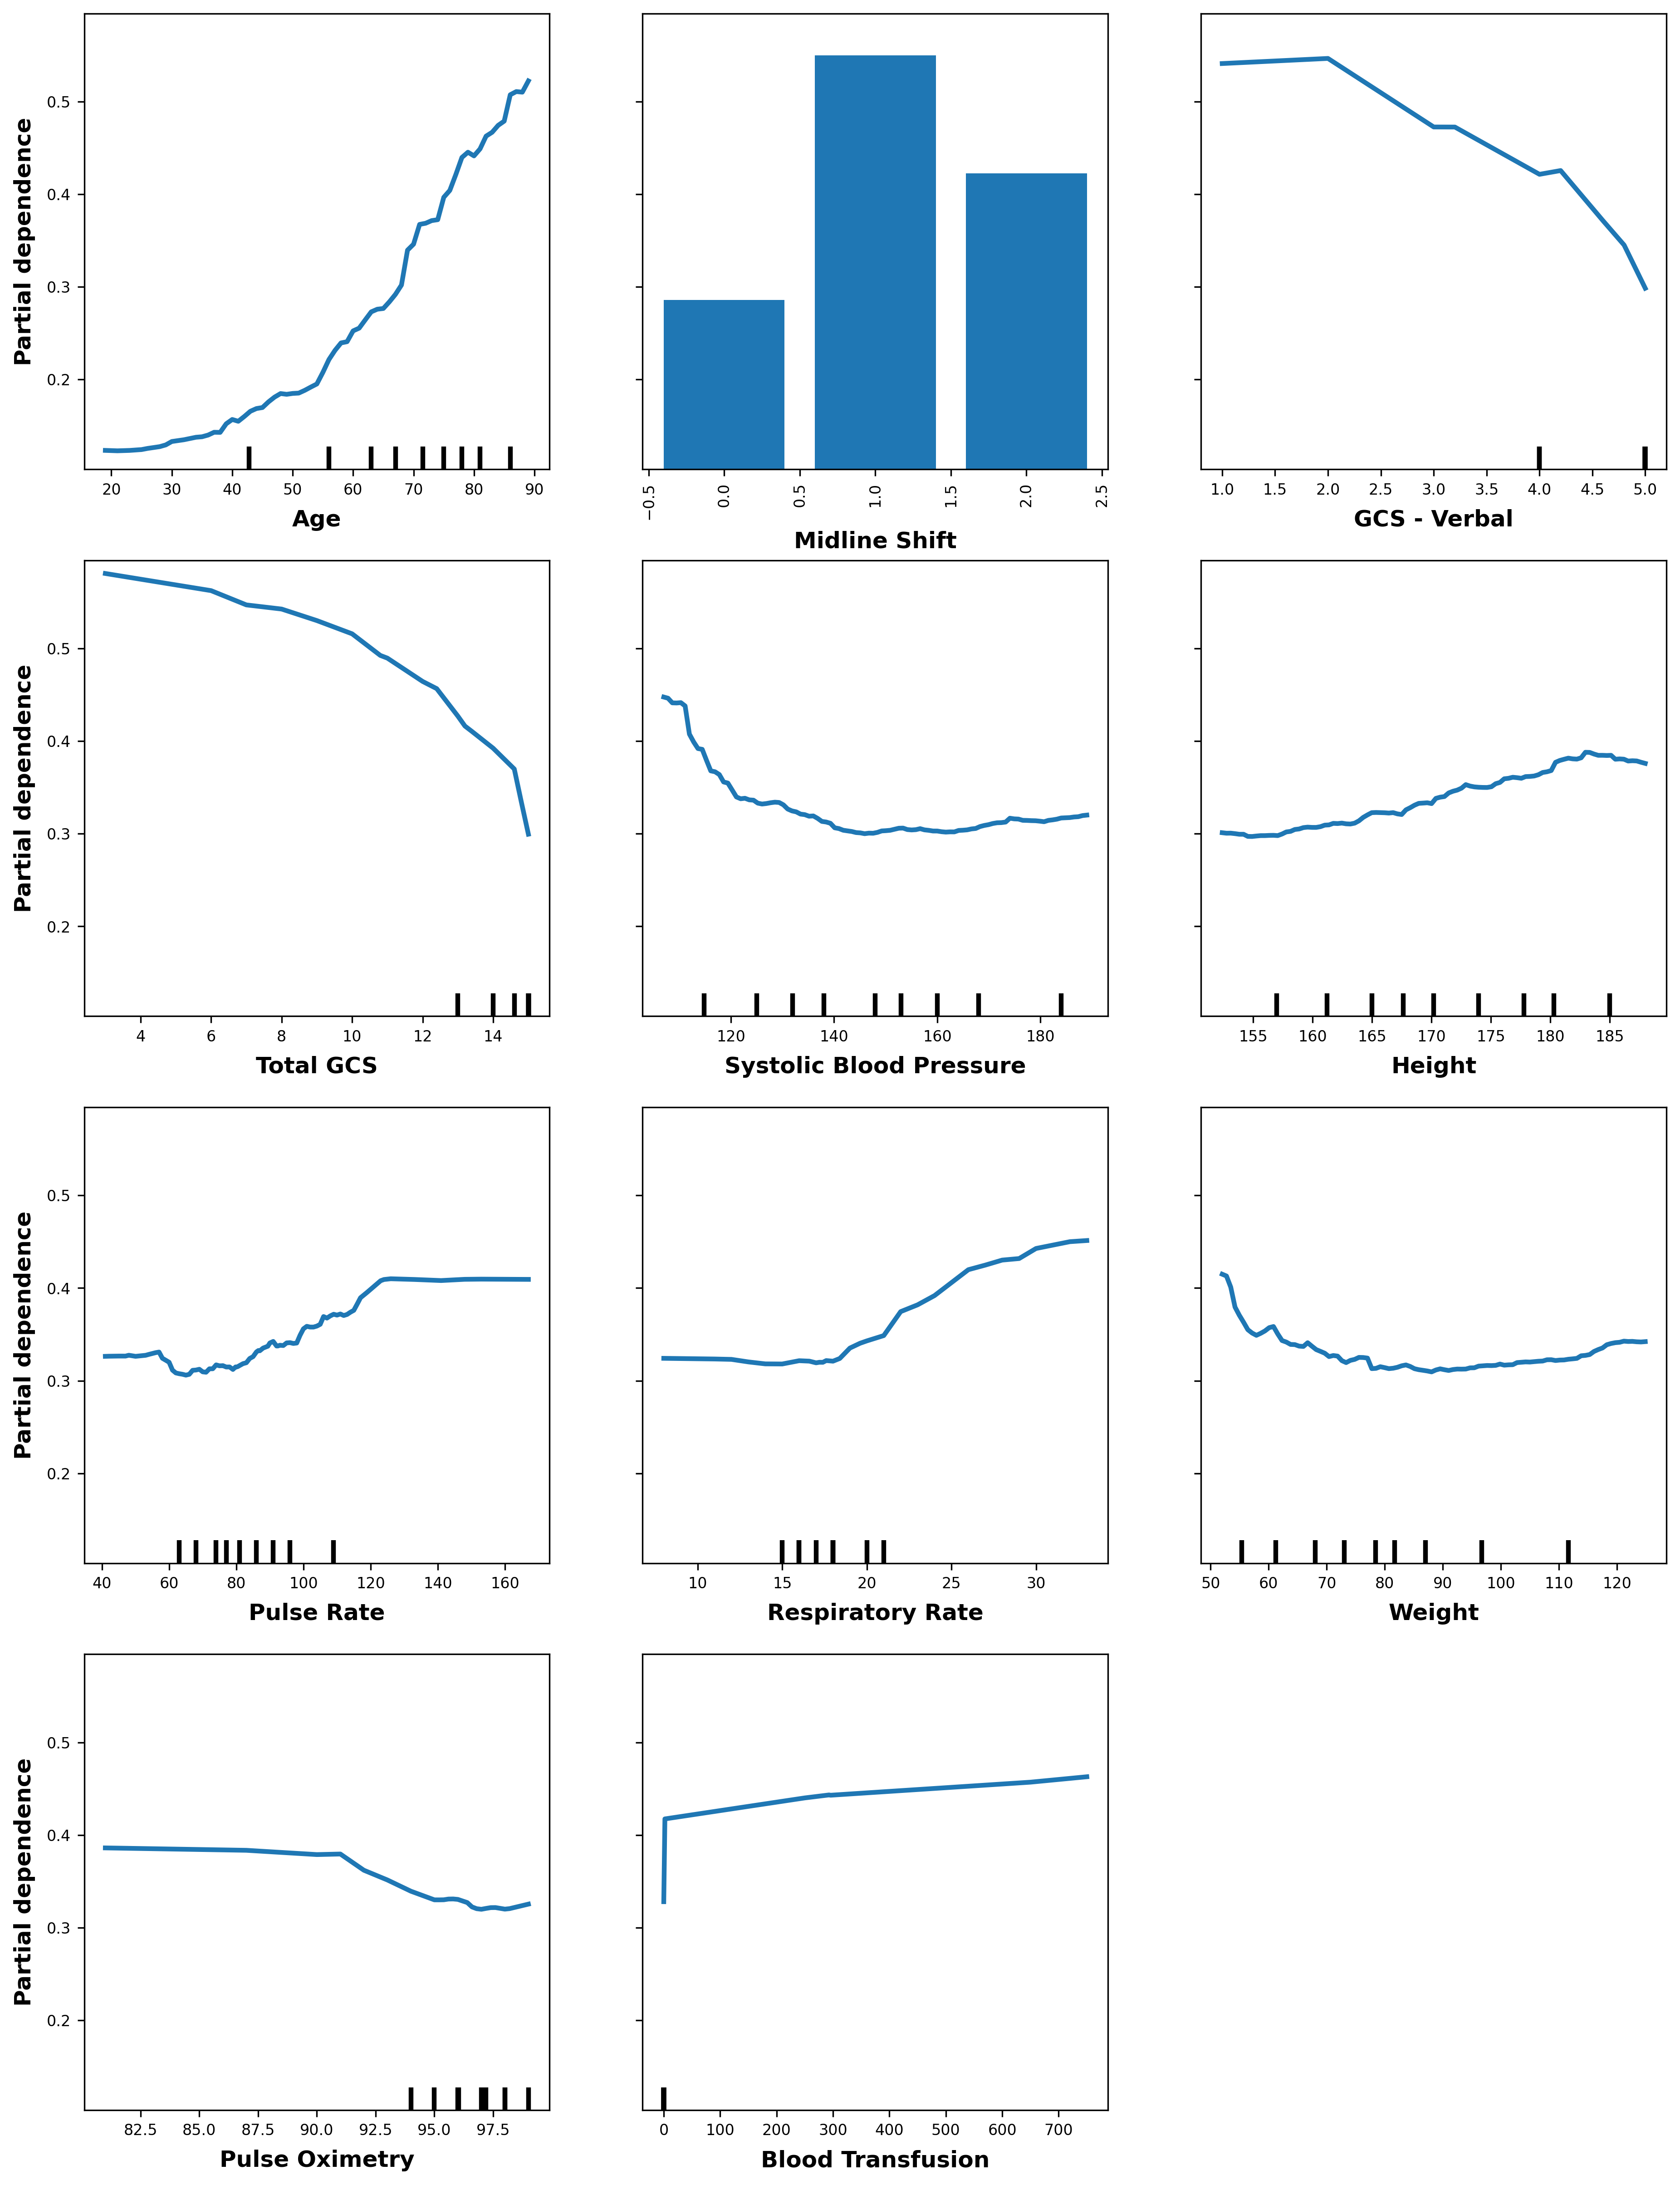

In [73]:
#Calculate the mean absolute SHAP values for each feature.
rf_mean_abs_shap_values = np.mean(np.abs(rf_shap_values.values), axis=0)

#Create a DataFrame to map feature names to their mean absolute SHAP values.
rf_shap_summary = pd.DataFrame(list(zip(feature_names, rf_mean_abs_shap_values)), columns=['Feature', 'Mean SHAP'])

#Sort the DataFrame by 'Mean SHAP' in descending order.
rf_shap_summary_sorted = rf_shap_summary.sort_values('Mean SHAP', ascending=False)

#Get the names of the features.
rf_features = rf_shap_summary_sorted['Feature'].tolist()

PartialDependenceDisplay.from_estimator(rf, x_test_sample, rf_features, categorical_features = ['Midline Shift'])
pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/mortality_pdp_rf.png', dpi=300, bbox_inches='tight')
pyplot.show()